# Price Optimization using Linear Regression for a Retail Store

## 1. Framing the Business Problem

A small Retail Store sells burgers, coke, lemonade and coffee, individually and as combos. We have been requested to analyze the information provided as to find potential upsides in the P&L statement of the store. Given the information, we have to figure out if the pricing is correct, too low or too high. From a business perspective, we have no information about our competitors, benchmarks or any similar that could work as constraints in this model. We have to find the price that would give maximum profit to the Company, independently if it possible due to market conditions, competence or local law or regulation, corporate request, etc.

There are products whose sales are quite sensitive to their prices and as such a small change in their price can lead to noticeable change in their sales. While there are products whose sales are not much affected by their price.

From an economic perspective, elasticity is the degree to which the effective desire for something changes as its price changes. Precisely, price elasticity gives the percentage change in quantity demanded when there is a one percent increase in price, holding everything else constant.

In this notebook we will try to find the optimal pricing given no restraints.

## 2. Loading libraries and dataset

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
sold = pd.read_csv('Cafe - Sell Meta Data.csv')
transactions = pd.read_csv('Cafe - Transaction - Store.csv')
date_info = pd.read_csv('Cafe - DateInfo.csv')

## 3. Exploratory Data Analysis (EDA)

In [7]:
sold.head()

SELL_ID  SELL_CATEGORY  ITEM_ID ITEM_NAME
0     1070              0     7821    BURGER
1     3055              0     3052    COFFEE
2     3067              0     5030      COKE
3     3028              0     6249  LEMONADE
4     2051              2     7821    BURGER

In [8]:
sold.describe()
sold.describe(include = ['O']) 

SELL_ID  SELL_CATEGORY      ITEM_ID
count    11.000000      11.000000    11.000000
mean   2235.000000       1.272727  5906.909091
std     598.728653       1.009050  1830.217170
min    1070.000000       0.000000  3052.000000
25%    2051.500000       0.000000  5030.000000
50%    2053.000000       2.000000  6249.000000
75%    2540.500000       2.000000  7821.000000
max    3067.000000       2.000000  7821.000000

ITEM_NAME
count         11
unique         4
top       BURGER
freq           4

In [9]:
sold[sold.isnull().any(axis=1)]

Empty DataFrame
Columns: [SELL_ID, SELL_CATEGORY, ITEM_ID, ITEM_NAME]
Index: []

SELL_ID: a categorical variable, identifier of the combination of items that is contained in the product.

SELL_CATEGORY: “0” identifies single products; the category “2” identifies the combo ones.

ITEM_ID: a categorical variable, identifier of the item that is contained in the product.

ITEM_NAME: a categorical variable, identifying the name of the item

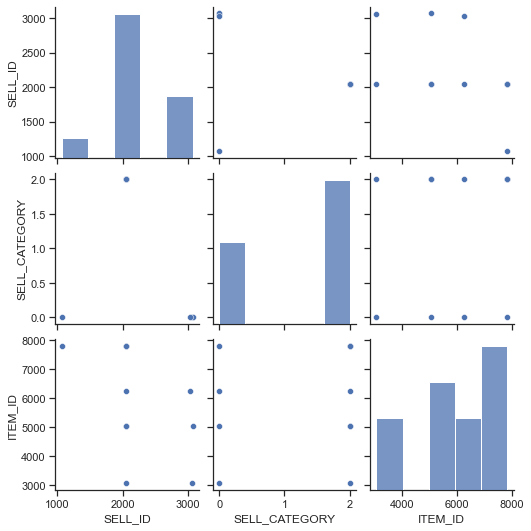

In [10]:
sns.pairplot(sold)

In [11]:
transactions.head()

CALENDAR_DATE  PRICE  QUANTITY  SELL_ID  SELL_CATEGORY
0      01/01/12  15.50        46     1070              0
1      01/01/12  12.73        22     2051              2
2      01/01/12  12.75        18     2052              2
3      01/01/12  12.60        30     2053              2
4      01/02/12  15.50        70     1070              0

In [12]:
transactions.describe()
transactions.describe(include = ['O'])

PRICE     QUANTITY     SELL_ID  SELL_CATEGORY
count  5404.000000  5404.000000  5404.00000    5404.000000
mean     12.868729    44.335307  1806.50000       1.500000
std       1.563922    25.502597   425.25841       0.866106
min      10.120000     8.000000  1070.00000       0.000000
25%      11.530000    24.000000  1805.75000       1.500000
50%      12.640000    36.000000  2051.50000       2.000000
75%      13.557500    60.000000  2052.25000       2.000000
max      16.500000   124.000000  2053.00000       2.000000

CALENDAR_DATE
count           5404
unique          1348
top         03/01/13
freq              16

In [13]:
transactions[transactions.isnull().any(axis=1)]

Empty DataFrame
Columns: [CALENDAR_DATE, PRICE, QUANTITY, SELL_ID, SELL_CATEGORY]
Index: []

Important: It’s supposed the PRICE for that product in that day will not vary.

In details:
CALENDAR_DATE: a date/time variable, having the time always set to 00:00 AM.

PRICE: a numeric variable, associated with the price of the product identified by the SELL_ID.

QUANTITY: a numeric variable, associated with the quantity of the product sold, identified by the SELL_ID.

SELL_ID: a categorical variable, identifier of the product sold.

SELL_CATEGORY: a categorical variable, category of the product sold.

<AxesSubplot:xlabel='PRICE', ylabel='Count'>

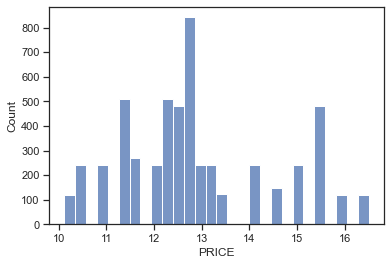

In [67]:
sns.histplot(transactions['PRICE'])

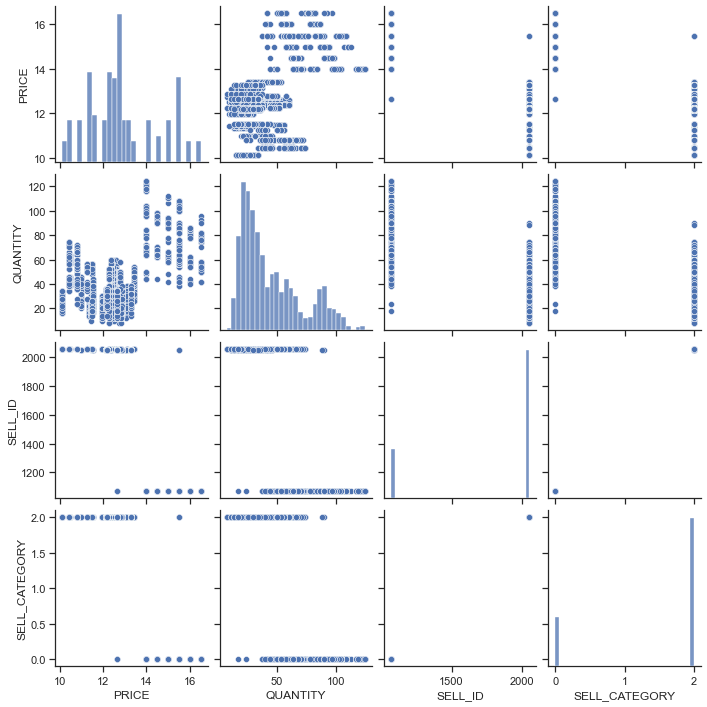

In [16]:
sns.pairplot(transactions)

In [17]:
date_info.head()

CALENDAR_DATE  YEAR   HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  \
0        1/1/12  2012  New Year           1               0   
1        1/2/12  2012  New Year           0               0   
2        1/3/12  2012  New Year           0               0   
3        1/4/12  2012       NaN           0               0   
4        1/5/12  2012       NaN           0               0   

   AVERAGE_TEMPERATURE  IS_OUTDOOR  
0                 24.8           0  
1                 24.8           0  
2                 32.0           1  
3                 32.0           1  
4                 24.8           0

In [18]:
date_info.describe()
date_info.describe(include = ['O'])

YEAR   IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  \
count  1349.000000  1349.000000     1349.000000          1349.000000   
mean   2013.375093     0.285397        0.204596            56.326019   
std       1.073073     0.451771        0.403556            20.227597   
min    2012.000000     0.000000        0.000000            14.000000   
25%    2012.000000     0.000000        0.000000            35.600000   
50%    2013.000000     0.000000        0.000000            60.800000   
75%    2014.000000     1.000000        0.000000            75.200000   
max    2015.000000     1.000000        1.000000            87.800000   

        IS_OUTDOOR  
count  1349.000000  
mean      0.862120  
std       0.344902  
min       0.000000  
25%       1.000000  
50%       1.000000  
75%       1.000000  
max       1.000000

CALENDAR_DATE         HOLIDAY
count           1349             105
unique          1348               8
top           3/1/13  Luner New Year
freq               2              28

In [19]:
date_info.dtypes

CALENDAR_DATE           object
YEAR                     int64
HOLIDAY                 object
IS_WEEKEND               int64
IS_SCHOOLBREAK           int64
AVERAGE_TEMPERATURE    float64
IS_OUTDOOR               int64
dtype: object

In [20]:
date_info[date_info.isnull().any(axis=1)]

CALENDAR_DATE  YEAR HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  \
3           1/4/12  2012     NaN           0               0   
4           1/5/12  2012     NaN           0               0   
5           1/6/12  2012     NaN           0               0   
6           1/7/12  2012     NaN           1               0   
7           1/8/12  2012     NaN           1               0   
8           1/9/12  2012     NaN           0               0   
9          1/10/12  2012     NaN           0               0   
10         1/11/12  2012     NaN           0               0   
11         1/12/12  2012     NaN           0               0   
12         1/13/12  2012     NaN           0               0   
13         1/14/12  2012     NaN           1               0   
14         1/15/12  2012     NaN           1               0   
15         1/16/12  2012     NaN           0               0   
16         1/17/12  2012     NaN           0               0   
17         1/18/12  2012     NaN           0               0   
18         1/19/12  2012     NaN           0               0   
19         1/20/12  2012     NaN           0               0   
20         1/21/12  2012     NaN           1               0   
21         1/22/12  2012     NaN           1               0   
22         1/23/12  2012     NaN           0               0   
23         1/24/12  2012     NaN           0               0   
24         1/25/12  2012     NaN           0               0   
25         1/26/12  2012     NaN           0               0   
26         1/27/12  2012     NaN           0               0   
27         1/28/12  2012     NaN           1               0   
28         1/29/12  2012     NaN           1               0   
29         1/30/12  2012     NaN           0               0   
30         1/31/12  2012     NaN           0               0   
31          2/1/12  2012     NaN           0               0   
39          2/9/12  2012     NaN           0               0   
40         2/10/12  2012     NaN           0               0   
41         2/11/12  2012     NaN           1               0   
42         2/12/12  2012     NaN           1               0   
43         2/13/12  2012     NaN           0               0   
44         2/14/12  2012     NaN           0               0   
45         2/15/12  2012     NaN           0               0   
46         2/16/12  2012     NaN           0               0   
47         2/17/12  2012     NaN           0               0   
48         2/18/12  2012     NaN           1               0   
49         2/19/12  2012     NaN           1               0   
50         2/20/12  2012     NaN           0               0   
51         2/21/12  2012     NaN           0               0   
52         2/22/12  2012     NaN           0               0   
53         2/23/12  2012     NaN           0               0   
54         2/24/12  2012     NaN           0               0   
55         2/25/12  2012     NaN           1               0   
56         2/26/12  2012     NaN           1               0   
57         2/27/12  2012     NaN           0               0   
58         2/28/12  2012     NaN           0               0   
59          3/1/12  2012     NaN           0               0   
60          3/2/12  2012     NaN           0               0   
61          3/3/12  2012     NaN           1               0   
62          3/4/12  2012     NaN           1               0   
63          3/5/12  2012     NaN           0               0   
64          3/6/12  2012     NaN           0               0   
65          3/7/12  2012     NaN           0               0   
66          3/8/12  2012     NaN           0               0   
67          3/9/12  2012     NaN           0               0   
68         3/10/12  2012     NaN           1               0   
69         3/11/12  2012     NaN           1               0   
70         3/12/12  2012     NaN           0               0   
71         3/13/12  2012     NaN     

In [21]:
date_info['HOLIDAY'] = date_info['HOLIDAY'].fillna("No Holiday")

In [22]:
date_info

CALENDAR_DATE  YEAR               HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  \
0           1/1/12  2012              New Year           1               0   
1           1/2/12  2012              New Year           0               0   
2           1/3/12  2012              New Year           0               0   
3           1/4/12  2012            No Holiday           0               0   
4           1/5/12  2012            No Holiday           0               0   
5           1/6/12  2012            No Holiday           0               0   
6           1/7/12  2012            No Holiday           1               0   
7           1/8/12  2012            No Holiday           1               0   
8           1/9/12  2012            No Holiday           0               0   
9          1/10/12  2012            No Holiday           0               0   
10         1/11/12  2012            No Holiday           0               0   
11         1/12/12  2012            No Holiday           0               0   
12         1/13/12  2012            No Holiday           0               0   
13         1/14/12  2012            No Holiday           1               0   
14         1/15/12  2012            No Holiday           1               0   
15         1/16/12  2012            No Holiday           0               0   
16         1/17/12  2012            No Holiday           0               0   
17         1/18/12  2012            No Holiday           0               0   
18         1/19/12  2012            No Holiday           0               0   
19         1/20/12  2012            No Holiday           0               0   
20         1/21/12  2012            No Holiday           1               0   
21         1/22/12  2012            No Holiday           1               0   
22         1/23/12  2012            No Holiday           0               0   
23         1/24/12  2012            No Holiday           0               0   
24         1/25/12  2012            No Holiday           0               0   
25         1/26/12  2012            No Holiday           0               0   
26         1/27/12  2012            No Holiday           0               0   
27         1/28/12  2012            No Holiday           1               0   
28         1/29/12  2012            No Holiday           1               0   
29         1/30/12  2012            No Holiday           0               0   
30         1/31/12  2012            No Holiday           0               0   
31          2/1/12  2012            No Holiday           0               0   
32          2/2/12  2012        Luner New Year           0               0   
33          2/3/12  2012        Luner New Year           0               0   
34          2/4/12  2012        Luner New Year           1               0   
35          2/5/12  2012        Luner New Year           1               0   
36          2/6/12  2012        Luner New Year           0               0   
37          2/7/12  2012        Luner New Year           0               0   
38          2/8/12  2012        Luner New Year           0               0   
39          2/9/12  2012            No Holiday           0               0   
40         2/10/12  2012            No Holiday           0               0   
41         2/11/12  2012            No Holiday           1               0   
42         2/12/12  2012            No Holiday           1               0   
43         2/13/12  2012            No Holiday           0               0   
44         2/14/12  2012            No Holiday           0               0   
45         2/15/12  2012            No Holiday           0               0   
46         2/16/12  2012            No Holiday           0               0   
47         2/17/12  2012            No Holiday           0               0   
48         2/18/12  2012            No Holiday           1               0   
49         2/19/12  2012            No Holiday           1               0   
50         2/20/12  2012   

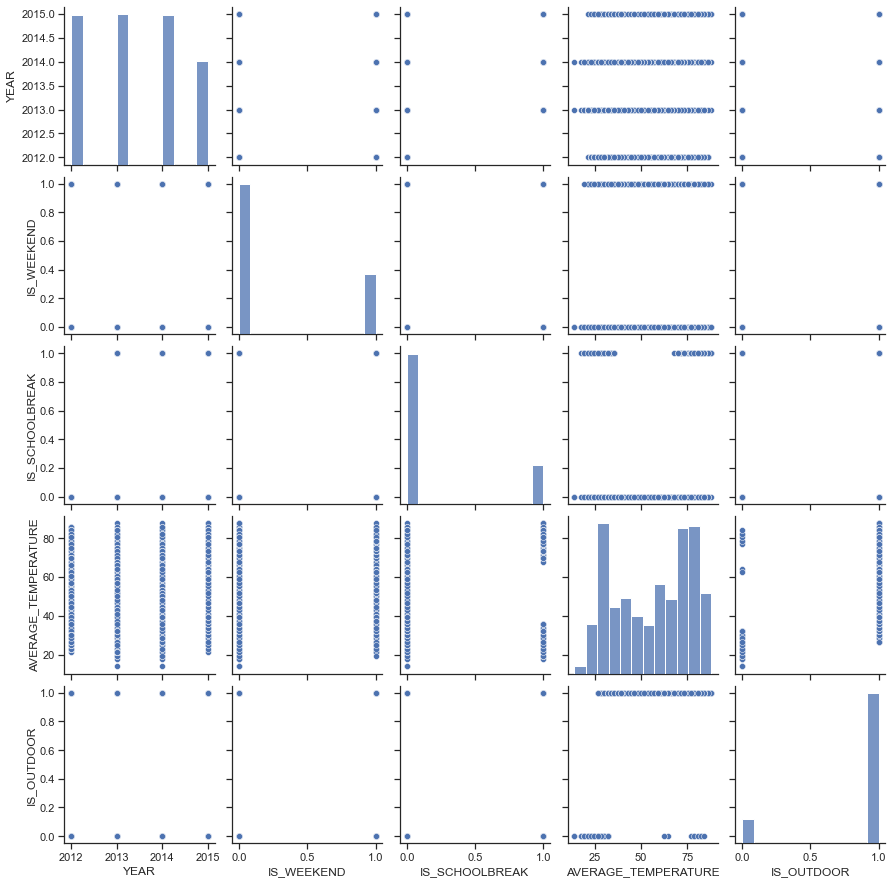

In [23]:
sns.pairplot(date_info)

In [24]:
np.unique(date_info['HOLIDAY'])

array(['Dragon Boat Festivel', 'Labor Day', 'Luner New Year',
       'Mid-Autumn Day', 'National Day', 'New Year', 'No Holiday',
       'Qing Ming Festival', 'WWII Celebration'], dtype=object)

In [25]:
date_info['CALENDAR_DATE'].min()

'1/1/12'

In [26]:
date_info['CALENDAR_DATE'].max()

'9/9/15'

In [27]:
date_info.shape

(1349, 7)

In [28]:
date_info[date_info.isnull().any(axis=1)]

Empty DataFrame
Columns: [CALENDAR_DATE, YEAR, HOLIDAY, IS_WEEKEND, IS_SCHOOLBREAK, AVERAGE_TEMPERATURE, IS_OUTDOOR]
Index: []

In [29]:
pd.concat([sold.SELL_ID, pd.get_dummies(sold.ITEM_NAME)], axis=1)

SELL_ID  BURGER  COFFEE  COKE  LEMONADE
0      1070       1       0     0         0
1      3055       0       1     0         0
2      3067       0       0     1         0
3      3028       0       0     0         1
4      2051       1       0     0         0
5      2051       0       0     1         0
6      2052       1       0     0         0
7      2052       0       0     0         1
8      2053       1       0     0         0
9      2053       0       0     1         0
10     2053       0       1     0         0

In [30]:
pd.concat([sold.SELL_ID, pd.get_dummies(sold.ITEM_NAME)], axis=1).groupby(sold.SELL_ID).sum()

SELL_ID  BURGER  COFFEE  COKE  LEMONADE
SELL_ID                                         
1070        1070       1       0     0         0
2051        4102       1       0     1         0
2052        4104       1       0     0         1
2053        6159       1       1     1         0
3028        3028       0       0     0         1
3055        3055       0       1     0         0
3067        3067       0       0     1         0

In [31]:
data1 = pd.merge(sold.drop(['ITEM_ID'],axis=1), transactions.drop(['SELL_CATEGORY'], axis= 1), on =  'SELL_ID')
data1.head(20)
b = data1.groupby(['SELL_ID', 'SELL_CATEGORY', 'ITEM_NAME', 'CALENDAR_DATE','PRICE']).QUANTITY.sum()

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY
0      1070              0    BURGER      01/01/12   15.5        46
1      1070              0    BURGER      01/02/12   15.5        70
2      1070              0    BURGER      01/03/12   15.5        62
3      1070              0    BURGER      01/04/12   15.5        88
4      1070              0    BURGER      01/05/12   15.5       104
5      1070              0    BURGER      01/06/12   15.5       100
6      1070              0    BURGER      01/07/12   15.5        70
7      1070              0    BURGER      01/08/12   15.5        70
8      1070              0    BURGER      01/09/12   15.5       106
9      1070              0    BURGER      01/10/12   15.5       108
10     1070              0    BURGER      01/11/12   15.5       104
11     1070              0    BURGER      01/12/12   15.5       102
12     1070              0    BURGER       1/13/12   15.5       100
13     1070              0    BURGER       1/14/12   15.5        74
14     1070              0    BURGER       1/15/12   15.5        60
15     1070              0    BURGER       1/16/12   15.5       104
16     1070              0    BURGER       1/17/12   15.5       106
17     1070              0    BURGER       1/18/12   15.5       108
18     1070              0    BURGER       1/19/12   15.5       100
19     1070              0    BURGER       1/20/12   15.5       100

In [32]:
b

SELL_ID  SELL_CATEGORY  ITEM_NAME  CALENDAR_DATE  PRICE
1070     0              BURGER     01/01/12       15.50     46
                                   01/01/13       15.50     60
                                   01/01/14       15.50     72
                                   01/01/15       14.00     66
                                   01/02/12       15.50     70
                                   01/02/13       15.50     68
                                   01/02/14       15.50     76
                                   01/02/15       14.00    102
                                   01/03/12       15.50     62
                                   01/03/13       15.50     70
                                   01/03/14       15.50     68
                                   01/03/15       14.00     68
                                   01/04/12       15.50     88
                                   01/04/13       15.50    100
                                   01/04/14       15.50     74

In [33]:
data1.shape
intermediate_data = b.reset_index()

(10808, 6)

In [34]:
data1.shape

(10808, 6)

In [35]:
b.shape

(10792,)

In [36]:
intermediate_data.head()

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY
0     1070              0    BURGER      01/01/12   15.5        46
1     1070              0    BURGER      01/01/13   15.5        60
2     1070              0    BURGER      01/01/14   15.5        72
3     1070              0    BURGER      01/01/15   14.0        66
4     1070              0    BURGER      01/02/12   15.5        70

In [37]:
intermediate_data['CALENDAR_DATE'].min()

'01/01/12'

In [38]:
intermediate_data['CALENDAR_DATE'].max()

'9/30/14'

In [39]:
combined_data = pd.merge(intermediate_data, date_info, on = 'CALENDAR_DATE')
combined_data.head()

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0     1070              0    BURGER       1/13/12  15.50       100  2012   
1     2051              2    BURGER       1/13/12  12.73        40  2012   
2     2051              2      COKE       1/13/12  12.73        40  2012   
3     2052              2    BURGER       1/13/12  12.75        26  2012   
4     2052              2  LEMONADE       1/13/12  12.75        26  2012   

      HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0  No Holiday           0               0                 26.6           0  
1  No Holiday           0               0                 26.6           0  
2  No Holiday           0               0                 26.6           0  
3  No Holiday           0               0                 26.6           0  
4  No Holiday           0               0                 26.6           0

In [40]:
combined_data.shape

(6696, 12)

In [41]:
combined_data[combined_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [SELL_ID, SELL_CATEGORY, ITEM_NAME, CALENDAR_DATE, PRICE, QUANTITY, YEAR, HOLIDAY, IS_WEEKEND, IS_SCHOOLBREAK, AVERAGE_TEMPERATURE, IS_OUTDOOR]
Index: []

In [42]:
np.unique(combined_data['HOLIDAY'])
np.unique(combined_data['IS_WEEKEND'])
np.unique(combined_data['IS_SCHOOLBREAK'])

array(['Dragon Boat Festivel', 'Labor Day', 'Luner New Year',
       'Mid-Autumn Day', 'No Holiday'], dtype=object)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

In [43]:
bau_data = combined_data[(combined_data['HOLIDAY']=='No Holiday') & (combined_data['IS_SCHOOLBREAK']==0) & (combined_data['IS_WEEKEND']==0)]

In [44]:
bau_data.head()

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0     1070              0    BURGER       1/13/12  15.50       100  2012   
1     2051              2    BURGER       1/13/12  12.73        40  2012   
2     2051              2      COKE       1/13/12  12.73        40  2012   
3     2052              2    BURGER       1/13/12  12.75        26  2012   
4     2052              2  LEMONADE       1/13/12  12.75        26  2012   

      HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0  No Holiday           0               0                 26.6           0  
1  No Holiday           0               0                 26.6           0  
2  No Holiday           0               0                 26.6           0  
3  No Holiday           0               0                 26.6           0  
4  No Holiday           0               0                 26.6           0

In [45]:
bau_data.shape

(3768, 12)

In [46]:
np.unique(bau_data['HOLIDAY'])
np.unique(bau_data['IS_WEEKEND'])
np.unique(bau_data['IS_SCHOOLBREAK'])

array(['No Holiday'], dtype=object)

array([0], dtype=int64)

array([0], dtype=int64)

In [47]:
bau_data[bau_data['IS_WEEKEND']==1]

Empty DataFrame
Columns: [SELL_ID, SELL_CATEGORY, ITEM_NAME, CALENDAR_DATE, PRICE, QUANTITY, YEAR, HOLIDAY, IS_WEEKEND, IS_SCHOOLBREAK, AVERAGE_TEMPERATURE, IS_OUTDOOR]
Index: []

In [48]:
bau_data[bau_data['HOLIDAY']!='No Holiday']

Empty DataFrame
Columns: [SELL_ID, SELL_CATEGORY, ITEM_NAME, CALENDAR_DATE, PRICE, QUANTITY, YEAR, HOLIDAY, IS_WEEKEND, IS_SCHOOLBREAK, AVERAGE_TEMPERATURE, IS_OUTDOOR]
Index: []

<AxesSubplot:xlabel='ITEM_NAME', ylabel='Count'>

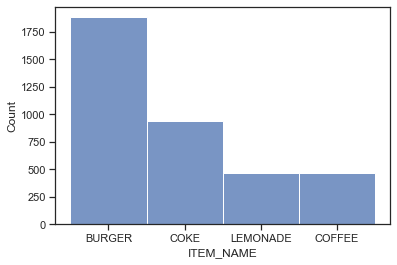

In [66]:
# Data exploration
sns.histplot(bau_data.ITEM_NAME)

<AxesSubplot:xlabel='PRICE', ylabel='Count'>

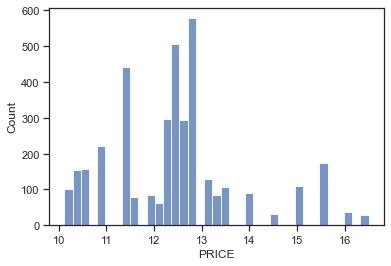

In [65]:
sns.histplot(bau_data.PRICE)

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

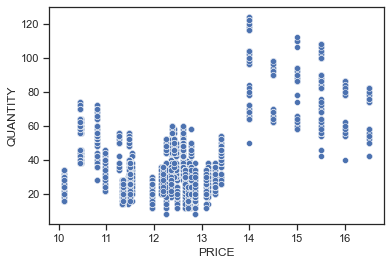

In [62]:
sns.scatterplot(combined_data['PRICE'], combined_data['QUANTITY'])

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

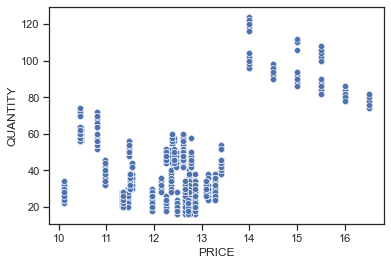

In [68]:
sns.scatterplot(bau_data['PRICE'], bau_data['QUANTITY'])

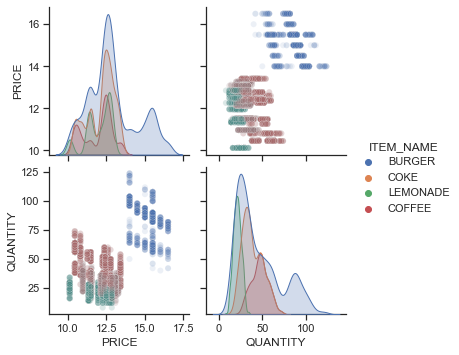

In [69]:
sns.pairplot(combined_data[['PRICE','QUANTITY','ITEM_NAME']], hue = 'ITEM_NAME', plot_kws={'alpha':0.1})

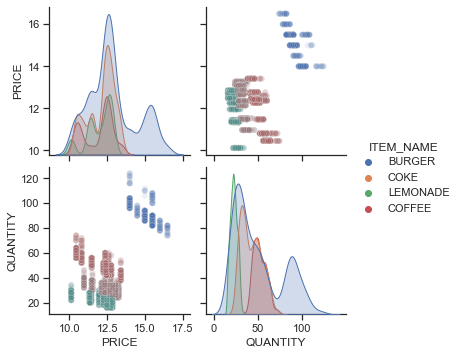

In [71]:
sns.pairplot(bau_data[['PRICE','QUANTITY','ITEM_NAME']], hue = 'ITEM_NAME', plot_kws={'alpha':0.1})

The price density plot is bimodal. From the graph we can see that for all quantities, as the price is increased the quantity sold is decreased. Although coke is hidden in this view. We xan go ahead and calculate the price elasticities for this.

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0     1070              0    BURGER       1/13/12  15.50       100  2012   
1     2051              2    BURGER       1/13/12  12.73        40  2012   
3     2052              2    BURGER       1/13/12  12.75        26  2012   
5     2053              2    BURGER       1/13/12  12.60        58  2012   
8     1070              0    BURGER       1/13/13  15.50        70  2013   

      HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0  No Holiday           0               0                 26.6           0  
1  No Holiday           0               0                 26.6           0  
3  No Holiday           0               0                 26.6           0  
5  No Holiday           0               0                 26.6           0  
8  No Holiday           1               0                 30.2           0

(3348, 12)

SELL_ID  SELL_CATEGORY        PRICE     QUANTITY         YEAR  \
count  3348.000000    3348.000000  3348.000000  3348.000000  3348.000000   
mean   1806.500000       1.500000    12.858572    44.974313  2013.351254   
std     425.282579       0.866155     1.565046    25.747886     1.062567   
min    1070.000000       0.000000    10.120000     8.000000  2012.000000   
25%    1805.750000       1.500000    11.530000    24.000000  2012.000000   
50%    2051.500000       2.000000    12.640000    36.000000  2013.000000   
75%    2052.250000       2.000000    13.557500    60.000000  2014.000000   
max    2053.000000       2.000000    16.500000   124.000000  2015.000000   

        IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE   IS_OUTDOOR  
count  3348.000000     3348.000000          3348.000000  3348.000000  
mean      0.284349        0.200717            56.255914     0.878136  
std       0.451171        0.400596            19.996348     0.327177  
min       0.000000        0.000000            14.000000     0.000000  
25%       0.000000        0.000000            35.600000     1.000000  
50%       0.000000        0.000000            59.000000     1.000000  
75%       1.000000        0.000000            75.200000     1.000000  
max       1.000000        1.000000            87.800000     1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

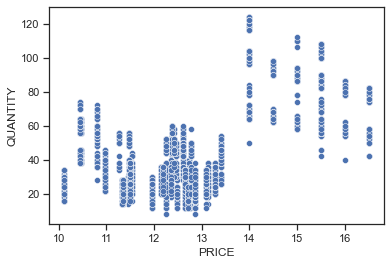

In [76]:
burger = combined_data[combined_data['ITEM_NAME'] == 'BURGER']
burger.head()
burger.shape
burger.describe()
sns.scatterplot(x = burger.PRICE, y = burger.QUANTITY)

From the above scatter plot it is clearly visible that there must be different types of burgers being sold. Now let's see the same distributin whenwe differentiate with SELL_ID which indicates if the burger was a part of the combo and hence, must be treated separately.

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

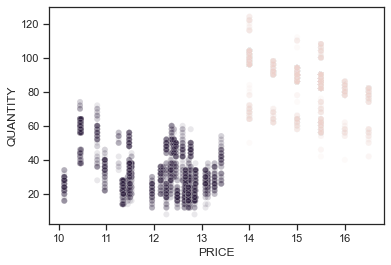

In [77]:
burger = combined_data[combined_data['ITEM_NAME'] == 'BURGER']
# print(burger)
# print(burger.describe())
sns.scatterplot(data = burger, x = burger.PRICE, y = burger.QUANTITY , hue = 'SELL_ID', legend=False, alpha = 0.1)

In [78]:
np.unique(combined_data.SELL_ID)

array([1070, 2051, 2052, 2053], dtype=int64)

In [79]:
np.unique(combined_data.SELL_CATEGORY)

array([0, 2], dtype=int64)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0      1070              0    BURGER       1/13/12   15.5       100  2012   
8      1070              0    BURGER       1/13/13   15.5        70  2013   
16     1070              0    BURGER       1/13/14   15.5       104  2014   
24     1070              0    BURGER       1/13/15   14.0       116  2015   
32     1070              0    BURGER       1/14/12   15.5        74  2012   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0   No Holiday           0               0                 26.6           0  
8   No Holiday           1               0                 30.2           0  
16  No Holiday           0               0                 28.4           0  
24  No Holiday           0               0                 28.4           0  
32  No Holiday           1               0                 23.0           0

SELL_ID  SELL_CATEGORY       PRICE    QUANTITY         YEAR  \
count    837.0          837.0  837.000000  837.000000   837.000000   
mean    1070.0            0.0   15.154719   82.685783  2013.351254   
std        0.0            0.0    0.744770   15.981238     1.063043   
min     1070.0            0.0   14.000000   40.000000  2012.000000   
25%     1070.0            0.0   14.500000   68.000000  2012.000000   
50%     1070.0            0.0   15.500000   86.000000  2013.000000   
75%     1070.0            0.0   15.500000   92.000000  2014.000000   
max     1070.0            0.0   16.500000  124.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
count  837.000000      837.000000           837.000000  837.000000  
mean     0.284349        0.200717            56.255914    0.878136  
std      0.451373        0.400776            20.005316    0.327324  
min      0.000000        0.000000            14.000000    0.000000  
25%      0.000000        0.000000            35.600000    1.000000  
50%      0.000000        0.000000            59.000000    1.000000  
75%      1.000000        0.000000            75.200000    1.000000  
max      1.000000        1.000000            87.800000    1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

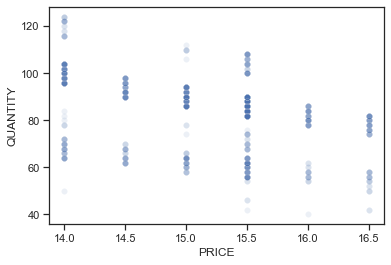

In [80]:
burger_1070 = combined_data[(combined_data['ITEM_NAME'] == 'BURGER') & (combined_data['SELL_ID'] == 1070)]

burger_1070.head()
burger_1070.describe()
sns.scatterplot(data = burger_1070, x = burger_1070.PRICE, y = burger_1070.QUANTITY, alpha = 0.1)

## 4. Modeling

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     153.9
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.45e-32
Time:                        15:38:58   Log-Likelihood:                -3436.0
No. Observations:                 837   AIC:                             6876.
Df Residuals:                     835   BIC:                             6885.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    210.9859     10.353     20.379      0.0

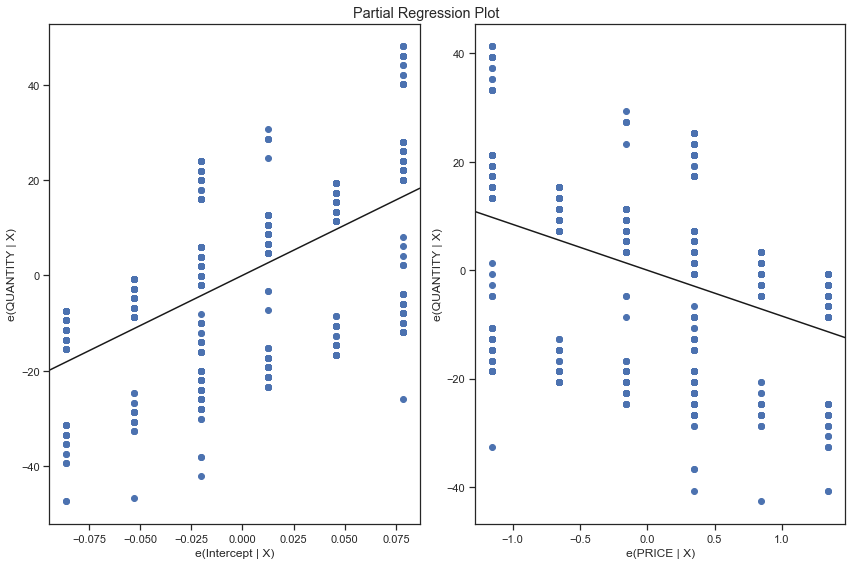

In [81]:
# This is for the combined data
burger_model = ols("QUANTITY ~ PRICE", data=burger_1070).fit()
print(burger_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_model, fig=fig)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0      1070              0    BURGER       1/13/12  15.50       100  2012   
1      2051              2    BURGER       1/13/12  12.73        40  2012   
3      2052              2    BURGER       1/13/12  12.75        26  2012   
5      2053              2    BURGER       1/13/12  12.60        58  2012   
16     1070              0    BURGER       1/13/14  15.50       104  2014   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0   No Holiday           0               0                 26.6           0  
1   No Holiday           0               0                 26.6           0  
3   No Holiday           0               0                 26.6           0  
5   No Holiday           0               0                 26.6           0  
16  No Holiday           0               0                 28.4           0

(1884, 12)

SELL_ID  SELL_CATEGORY        PRICE     QUANTITY         YEAR  \
count  1884.000000    1884.000000  1884.000000  1884.000000  1884.000000   
mean   1806.500000       1.500000    12.830340    49.562633  2013.186837   
std     425.331956       0.866255     1.567257    27.309516     1.058620   
min    1070.000000       0.000000    10.120000    16.000000  2012.000000   
25%    1805.750000       1.500000    11.530000    28.000000  2012.000000   
50%    2051.500000       2.000000    12.640000    40.000000  2013.000000   
75%    2052.250000       2.000000    13.557500    74.000000  2014.000000   
max    2053.000000       2.000000    16.500000   124.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE   IS_OUTDOOR  
count      1884.0          1884.0          1884.000000  1884.000000  
mean          0.0             0.0            53.691720     0.883227  
std           0.0             0.0            18.721922     0.321235  
min           0.0             0.0            14.000000     0.000000  
25%           0.0             0.0            35.600000     1.000000  
50%           0.0             0.0            53.600000     1.000000  
75%           0.0             0.0            71.600000     1.000000  
max           0.0             0.0            87.800000     1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

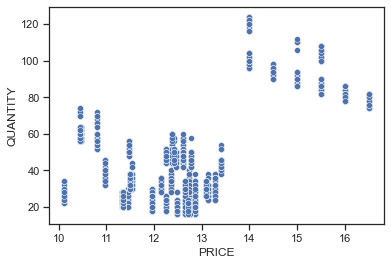

In [82]:
burger = bau_data[bau_data['ITEM_NAME'] == 'BURGER']
burger.head()
burger.shape
burger.describe()
sns.scatterplot(x = burger.PRICE, y = burger.QUANTITY )

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

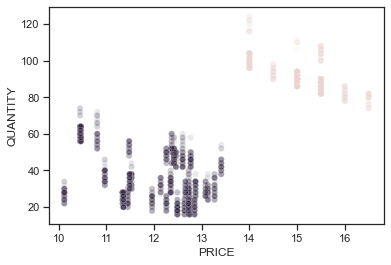

In [83]:
burger = bau_data[bau_data['ITEM_NAME'] == 'BURGER']
# print(burger)
# print(burger.describe())
sns.scatterplot(data = burger, x = burger.PRICE, y = burger.QUANTITY , hue = 'SELL_ID', legend=False, alpha = 0.1)

In [84]:
np.unique(bau_data.SELL_ID)

array([1070, 2051, 2052, 2053], dtype=int64)

In [85]:
np.unique(bau_data.SELL_CATEGORY)

array([0, 2], dtype=int64)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0      1070              0    BURGER       1/13/12   15.5       100  2012   
16     1070              0    BURGER       1/13/14   15.5       104  2014   
24     1070              0    BURGER       1/13/15   14.0       116  2015   
48     1070              0    BURGER       1/14/14   15.5        86  2014   
56     1070              0    BURGER       1/14/15   14.0       122  2015   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0   No Holiday           0               0                 26.6           0  
16  No Holiday           0               0                 28.4           0  
24  No Holiday           0               0                 28.4           0  
48  No Holiday           0               0                 28.4           1  
56  No Holiday           0               0                 30.2           0

SELL_ID  SELL_CATEGORY       PRICE    QUANTITY         YEAR  \
count    471.0          471.0  471.000000  471.000000   471.000000   
mean    1070.0            0.0   15.124204   91.622081  2013.186837   
std        0.0            0.0    0.705577    9.437897     1.059464   
min     1070.0            0.0   14.000000   74.000000  2012.000000   
25%     1070.0            0.0   14.500000   86.000000  2012.000000   
50%     1070.0            0.0   15.500000   90.000000  2013.000000   
75%     1070.0            0.0   15.500000   98.000000  2014.000000   
max     1070.0            0.0   16.500000  124.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
count       471.0           471.0           471.000000  471.000000  
mean          0.0             0.0            53.691720    0.883227  
std           0.0             0.0            18.736854    0.321491  
min           0.0             0.0            14.000000    0.000000  
25%           0.0             0.0            35.600000    1.000000  
50%           0.0             0.0            53.600000    1.000000  
75%           0.0             0.0            70.700000    1.000000  
max           0.0             0.0            87.800000    1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

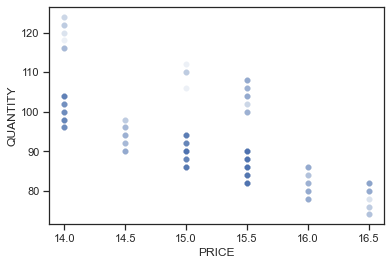

In [86]:
burger_1070 = bau_data[(bau_data['ITEM_NAME'] == 'BURGER') & (bau_data['SELL_ID'] == 1070)]

burger_1070.head()
burger_1070.describe()
sns.scatterplot(data = burger_1070, x = burger_1070.PRICE, y = burger_1070.QUANTITY, alpha = 0.1)

As you can see, the scatter plot is much cleaner. Although there does seem to be 2 separate trends

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     444.2
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           7.16e-70
Time:                        15:39:41   Log-Likelihood:                -1568.2
No. Observations:                 471   AIC:                             3140.
Df Residuals:                     469   BIC:                             3149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    232.7193      6.702     34.726      0.0

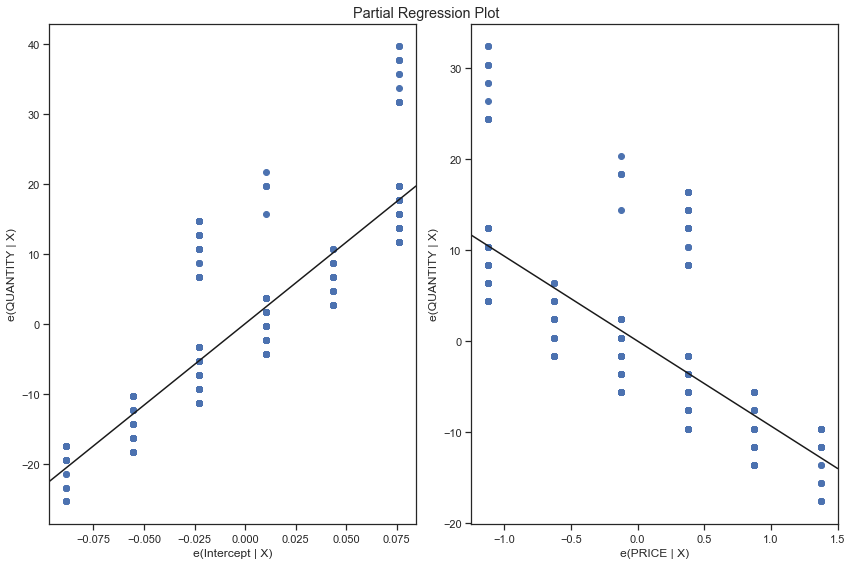

In [87]:
burger_model = ols("QUANTITY ~ PRICE", data=burger_1070).fit()
print(burger_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_model, fig=fig)

Let's look at the bau data again to see if there is anything els in the data we can use to further refine our model.

In [88]:
bau_data.head()

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
0     1070              0    BURGER       1/13/12  15.50       100  2012   
1     2051              2    BURGER       1/13/12  12.73        40  2012   
2     2051              2      COKE       1/13/12  12.73        40  2012   
3     2052              2    BURGER       1/13/12  12.75        26  2012   
4     2052              2  LEMONADE       1/13/12  12.75        26  2012   

      HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
0  No Holiday           0               0                 26.6           0  
1  No Holiday           0               0                 26.6           0  
2  No Holiday           0               0                 26.6           0  
3  No Holiday           0               0                 26.6           0  
4  No Holiday           0               0                 26.6           0

In [89]:
bau2_data = combined_data[(combined_data['HOLIDAY']=='No Holiday') & (combined_data['IS_SCHOOLBREAK']==0) & (combined_data['IS_WEEKEND']==0) & (combined_data['IS_OUTDOOR']==1)]

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
48      1070              0    BURGER       1/14/14   15.5        86  2014   
88      1070              0    BURGER       1/15/15   14.0       104  2015   
120     1070              0    BURGER       1/16/15   14.0       100  2015   
448     1070              0    BURGER       1/27/12   15.5        86  2012   
576     1070              0    BURGER       1/31/12   15.5        84  2012   

        HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
48   No Holiday           0               0                 28.4           1  
88   No Holiday           0               0                 32.0           1  
120  No Holiday           0               0                 32.0           1  
448  No Holiday           0               0                 32.0           1  
576  No Holiday           0               0                 32.0           1

SELL_ID  SELL_CATEGORY       PRICE    QUANTITY         YEAR  \
count    416.0          416.0  416.000000  416.000000   416.000000   
mean    1070.0            0.0   15.139423   89.274038  2013.201923   
std        0.0            0.0    0.709511    6.811889     1.076628   
min     1070.0            0.0   14.000000   74.000000  2012.000000   
25%     1070.0            0.0   14.500000   84.000000  2012.000000   
50%     1070.0            0.0   15.000000   88.000000  2013.000000   
75%     1070.0            0.0   15.500000   94.000000  2014.000000   
max     1070.0            0.0   16.500000  104.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
count       416.0           416.0           416.000000       416.0  
mean          0.0             0.0            57.282212         1.0  
std           0.0             0.0            16.890613         0.0  
min           0.0             0.0            26.600000         1.0  
25%           0.0             0.0            41.000000         1.0  
50%           0.0             0.0            59.000000         1.0  
75%           0.0             0.0            71.600000         1.0  
max           0.0             0.0            87.800000         1.0

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

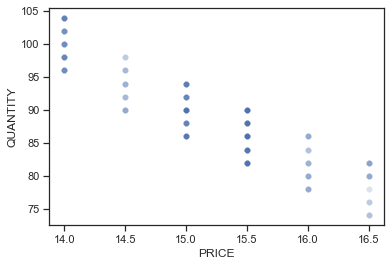

In [90]:
burger_1070 = bau2_data[(bau2_data['ITEM_NAME'] == 'BURGER') & (bau2_data['SELL_ID'] == 1070)]

burger_1070.head()
burger_1070.describe()
sns.scatterplot(data = burger_1070, x = burger_1070.PRICE, y = burger_1070.QUANTITY, alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1804.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):          5.51e-153
Time:                        15:40:13   Log-Likelihood:                -1038.8
No. Observations:                 416   AIC:                             2082.
Df Residuals:                     414   BIC:                             2090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    220.3600      3.090     71.322      0.0

<Figure size 864x576 with 0 Axes>

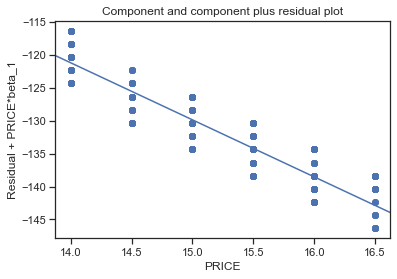

In [91]:
burger_model = ols("QUANTITY ~ PRICE", data=burger_1070).fit()
print(burger_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_ccpr(burger_model, "PRICE")

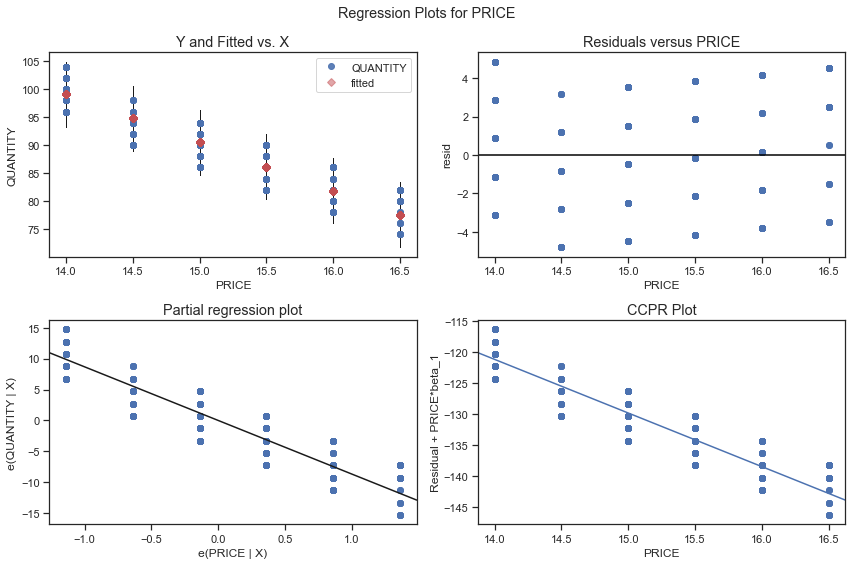

In [92]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(burger_model, "PRICE", fig=fig)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
1      2051              2    BURGER       1/13/12  12.73        40  2012   
9      2051              2    BURGER       1/13/13  13.13        26  2013   
17     2051              2    BURGER       1/13/14  13.27        38  2014   
25     2051              2    BURGER       1/13/15  11.53        38  2015   
33     2051              2    BURGER       1/14/12  12.73        24  2012   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
1   No Holiday           0               0                 26.6           0  
9   No Holiday           1               0                 30.2           0  
17  No Holiday           0               0                 28.4           0  
25  No Holiday           0               0                 28.4           0  
33  No Holiday           1               0                 23.0           0

SELL_ID  SELL_CATEGORY       PRICE    QUANTITY         YEAR  \
count    837.0          837.0  837.000000  837.000000   837.000000   
mean    2051.0            2.0   12.368017   29.498208  2013.351254   
std        0.0            0.0    0.726329    5.782878     1.063043   
min     2051.0            2.0   10.970000   12.000000  2012.000000   
25%     2051.0            2.0   11.530000   26.000000  2012.000000   
50%     2051.0            2.0   12.660000   30.000000  2013.000000   
75%     2051.0            2.0   13.080000   34.000000  2014.000000   
max     2051.0            2.0   13.270000   46.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
count  837.000000      837.000000           837.000000  837.000000  
mean     0.284349        0.200717            56.255914    0.878136  
std      0.451373        0.400776            20.005316    0.327324  
min      0.000000        0.000000            14.000000    0.000000  
25%      0.000000        0.000000            35.600000    1.000000  
50%      0.000000        0.000000            59.000000    1.000000  
75%      1.000000        0.000000            75.200000    1.000000  
max      1.000000        1.000000            87.800000    1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

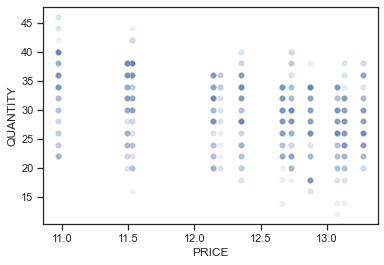

In [93]:
burger_2051 = combined_data[(combined_data['ITEM_NAME'] == 'BURGER') & (combined_data['SELL_ID'] == 2051)]

burger_2051.head()
burger_2051.describe()
sns.scatterplot(data = burger_2051, x = burger_2051.PRICE, y = burger_2051.QUANTITY, alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           4.45e-27
Time:                        15:40:32   Log-Likelihood:                -2597.8
No. Observations:                 837   AIC:                             5200.
Df Residuals:                     835   BIC:                             5209.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.9906      3.184     20.411      0.0

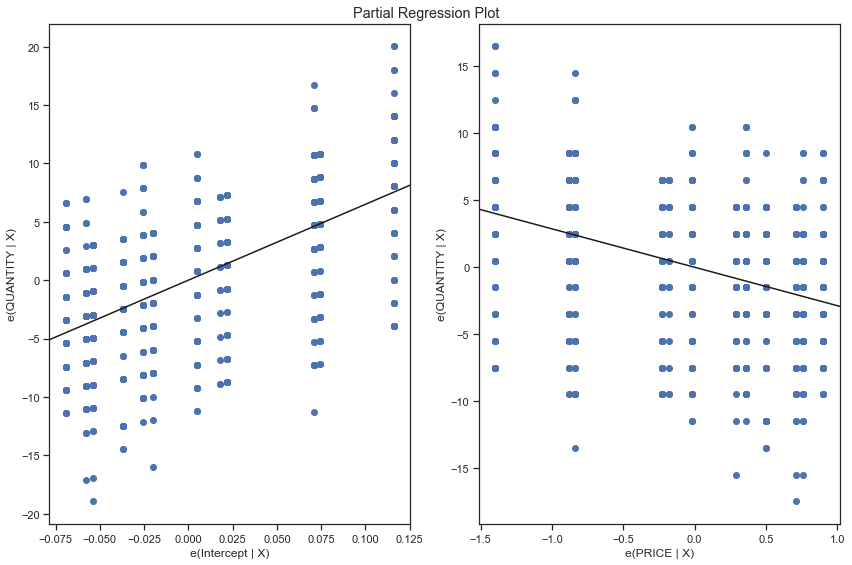

In [94]:
burger_model = ols("QUANTITY ~ PRICE", data=burger_2051).fit()
print(burger_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(burger_model, fig=fig)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
2      2051              2      COKE       1/13/12  12.73        40  2012   
7      2053              2      COKE       1/13/12  12.60        58  2012   
10     2051              2      COKE       1/13/13  13.13        26  2013   
15     2053              2      COKE       1/13/13  13.41        32  2013   
18     2051              2      COKE       1/13/14  13.27        38  2014   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
2   No Holiday           0               0                 26.6           0  
7   No Holiday           0               0                 26.6           0  
10  No Holiday           1               0                 30.2           0  
15  No Holiday           1               0                 30.2           0  
18  No Holiday           0               0                 28.4           0

(1674, 12)

SELL_ID  SELL_CATEGORY        PRICE     QUANTITY         YEAR  \
count  1674.000000         1674.0  1674.000000  1674.000000  1674.000000   
mean   2052.000000            2.0    12.151326    38.150538  2013.351254   
std       1.000299            0.0     0.871405    11.861375     1.062726   
min    2051.000000            2.0    10.450000    12.000000  2012.000000   
25%    2051.000000            2.0    11.490000    30.000000  2012.000000   
50%    2052.000000            2.0    12.370000    36.000000  2013.000000   
75%    2053.000000            2.0    12.770000    48.000000  2014.000000   
max    2053.000000            2.0    13.410000    74.000000  2015.000000   

        IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE   IS_OUTDOOR  
count  1674.000000     1674.000000          1674.000000  1674.000000  
mean      0.284349        0.200717            56.255914     0.878136  
std       0.451239        0.400656            19.999336     0.327226  
min       0.000000        0.000000            14.000000     0.000000  
25%       0.000000        0.000000            35.600000     1.000000  
50%       0.000000        0.000000            59.000000     1.000000  
75%       1.000000        0.000000            75.200000     1.000000  
max       1.000000        1.000000            87.800000     1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

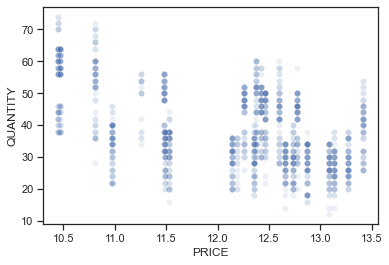

In [95]:
coke = combined_data[combined_data['ITEM_NAME'] == 'COKE']
coke.head()
coke.shape
coke.describe()
sns.scatterplot(x = coke.PRICE, y = coke.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     544.2
Date:                Mon, 26 Jul 2021   Prob (F-statistic):          1.94e-104
Time:                        15:40:41   Log-Likelihood:                -6279.2
No. Observations:                1674   AIC:                         1.256e+04
Df Residuals:                    1672   BIC:                         1.257e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    120.1140      3.522     34.100      0.0

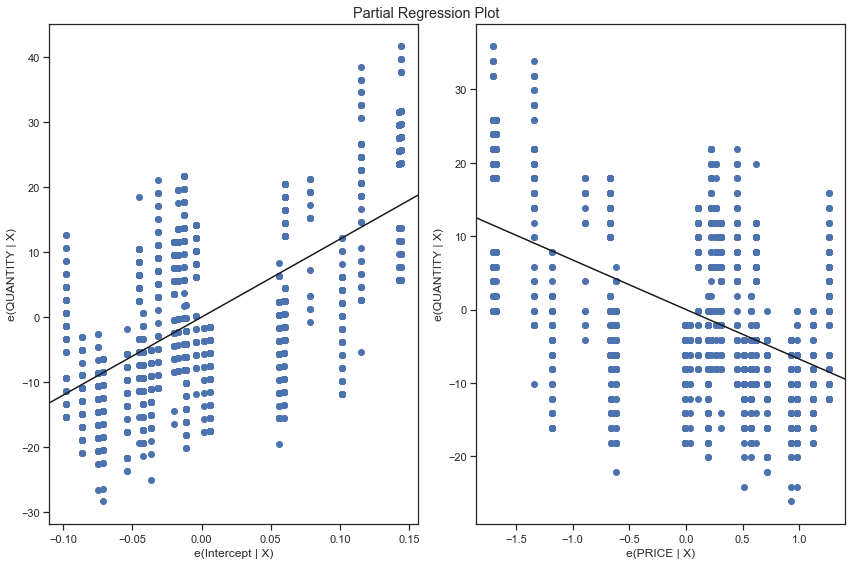

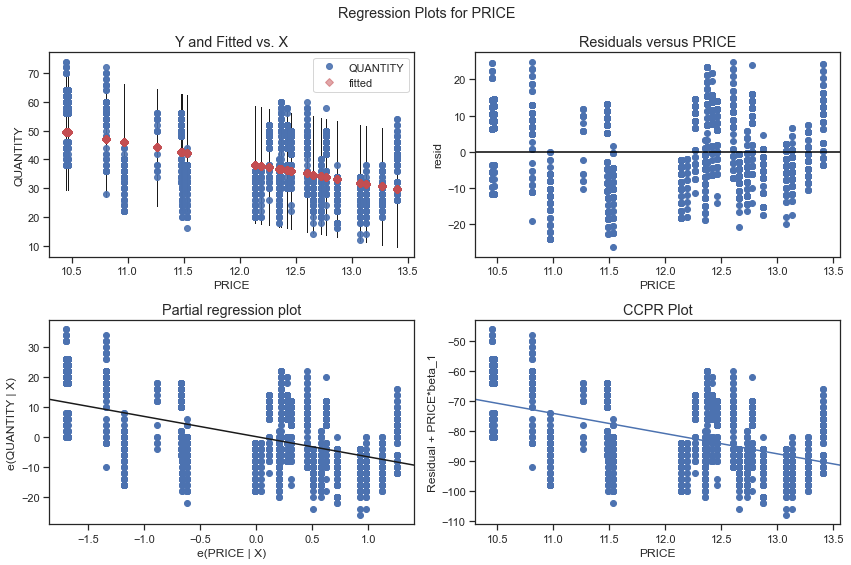

In [96]:
coke_model = ols("QUANTITY ~ PRICE", data=coke).fit()
print(coke_model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(coke_model, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(coke_model, 'PRICE', fig=fig)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
6      2053              2    COFFEE       1/13/12  12.60        58  2012   
14     2053              2    COFFEE       1/13/13  13.41        32  2013   
22     2053              2    COFFEE       1/13/14  12.37        60  2014   
30     2053              2    COFFEE       1/13/15  10.81        66  2015   
38     2053              2    COFFEE       1/14/12  12.60        42  2012   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
6   No Holiday           0               0                 26.6           0  
14  No Holiday           1               0                 30.2           0  
22  No Holiday           0               0                 28.4           0  
30  No Holiday           0               0                 28.4           0  
38  No Holiday           1               0                 23.0           0

(837, 12)

SELL_ID  SELL_CATEGORY       PRICE    QUANTITY         YEAR  \
count    837.0          837.0  837.000000  837.000000   837.000000   
mean    2053.0            2.0   11.934636   46.802867  2013.351254   
std        0.0            0.0    0.947643    9.909910     1.063043   
min     2053.0            2.0   10.450000   20.000000  2012.000000   
25%     2053.0            2.0   10.810000   40.000000  2012.000000   
50%     2053.0            2.0   12.370000   48.000000  2013.000000   
75%     2053.0            2.0   12.600000   54.000000  2014.000000   
max     2053.0            2.0   13.410000   74.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
count  837.000000      837.000000           837.000000  837.000000  
mean     0.284349        0.200717            56.255914    0.878136  
std      0.451373        0.400776            20.005316    0.327324  
min      0.000000        0.000000            14.000000    0.000000  
25%      0.000000        0.000000            35.600000    1.000000  
50%      0.000000        0.000000            59.000000    1.000000  
75%      1.000000        0.000000            75.200000    1.000000  
max      1.000000        1.000000            87.800000    1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

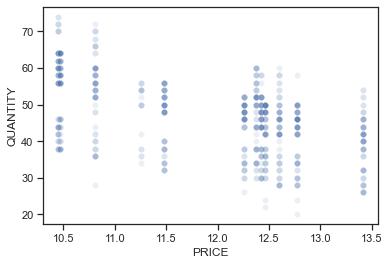

In [97]:
df = combined_data[combined_data['ITEM_NAME'] == 'COFFEE']
df.head()
df.shape
df.describe()
sns.scatterplot(x = df.PRICE, y = df.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     327.0
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           6.20e-62
Time:                        15:40:51   Log-Likelihood:                -2968.5
No. Observations:                 837   AIC:                             5941.
Df Residuals:                     835   BIC:                             5951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.0116      3.673     30.770      0.0

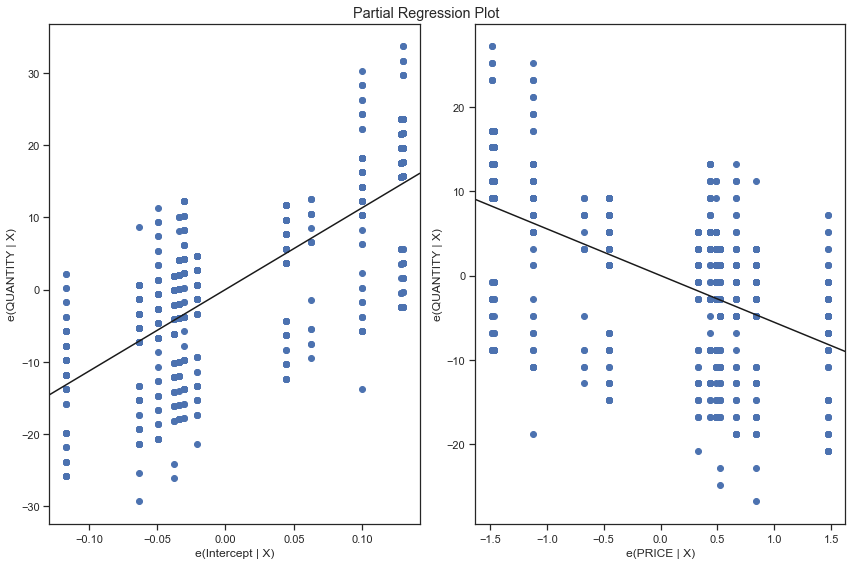

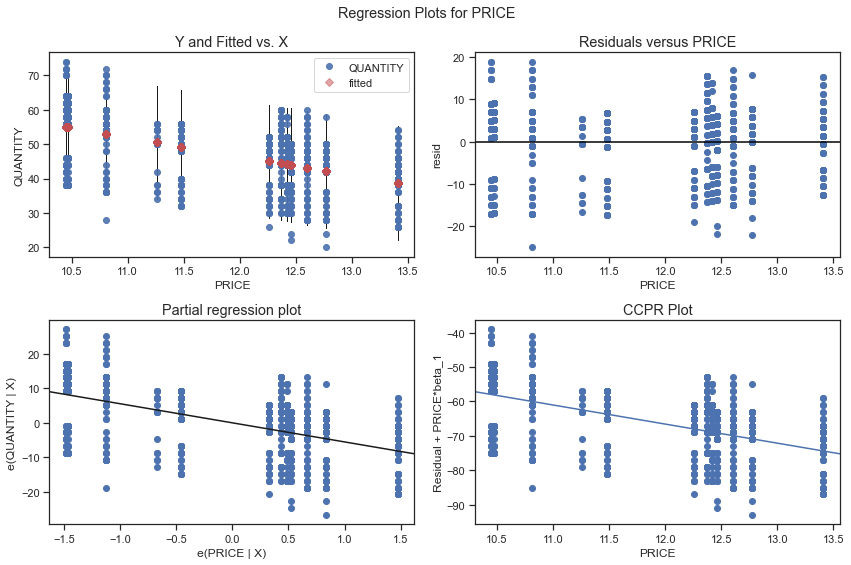

In [98]:
model = ols("QUANTITY ~ PRICE", data=df).fit()
print(model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'PRICE', fig=fig)

SELL_ID  SELL_CATEGORY ITEM_NAME CALENDAR_DATE  PRICE  QUANTITY  YEAR  \
4      2052              2  LEMONADE       1/13/12  12.75        26  2012   
12     2052              2  LEMONADE       1/13/13  12.64        18  2013   
20     2052              2  LEMONADE       1/13/14  11.96        24  2014   
28     2052              2  LEMONADE       1/13/15  11.45        28  2015   
36     2052              2  LEMONADE       1/14/12  12.75        20  2012   

       HOLIDAY  IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
4   No Holiday           0               0                 26.6           0  
12  No Holiday           1               0                 30.2           0  
20  No Holiday           0               0                 28.4           0  
28  No Holiday           0               0                 28.4           0  
36  No Holiday           1               0                 23.0           0

(837, 12)

SELL_ID  SELL_CATEGORY       PRICE    QUANTITY         YEAR  \
count    837.0          837.0  837.000000  837.000000   837.000000   
mean    2052.0            2.0   11.976918   20.910394  2013.351254   
std        0.0            0.0    0.820698    4.514501     1.063043   
min     2052.0            2.0   10.120000    8.000000  2012.000000   
25%     2052.0            2.0   11.360000   18.000000  2012.000000   
50%     2052.0            2.0   12.260000   20.000000  2013.000000   
75%     2052.0            2.0   12.720000   24.000000  2014.000000   
max     2052.0            2.0   12.850000   34.000000  2015.000000   

       IS_WEEKEND  IS_SCHOOLBREAK  AVERAGE_TEMPERATURE  IS_OUTDOOR  
count  837.000000      837.000000           837.000000  837.000000  
mean     0.284349        0.200717            56.255914    0.878136  
std      0.451373        0.400776            20.005316    0.327324  
min      0.000000        0.000000            14.000000    0.000000  
25%      0.000000        0.000000            35.600000    1.000000  
50%      0.000000        0.000000            59.000000    1.000000  
75%      1.000000        0.000000            75.200000    1.000000  
max      1.000000        1.000000            87.800000    1.000000

<AxesSubplot:xlabel='PRICE', ylabel='QUANTITY'>

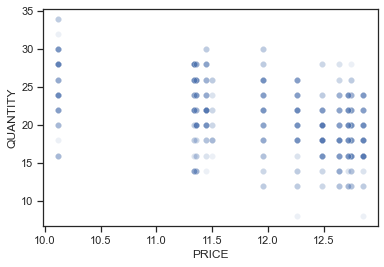

In [99]:
df = combined_data[combined_data['ITEM_NAME'] == 'LEMONADE']
df.head()
df.shape
df.describe()
sns.scatterplot(x = df.PRICE, y = df.QUANTITY , alpha = 0.1)

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     228.7
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           7.46e-46
Time:                        15:41:00   Log-Likelihood:                -2347.4
No. Observations:                 837   AIC:                             4699.
Df Residuals:                     835   BIC:                             4708.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     51.4615      2.025     25.416      0.0

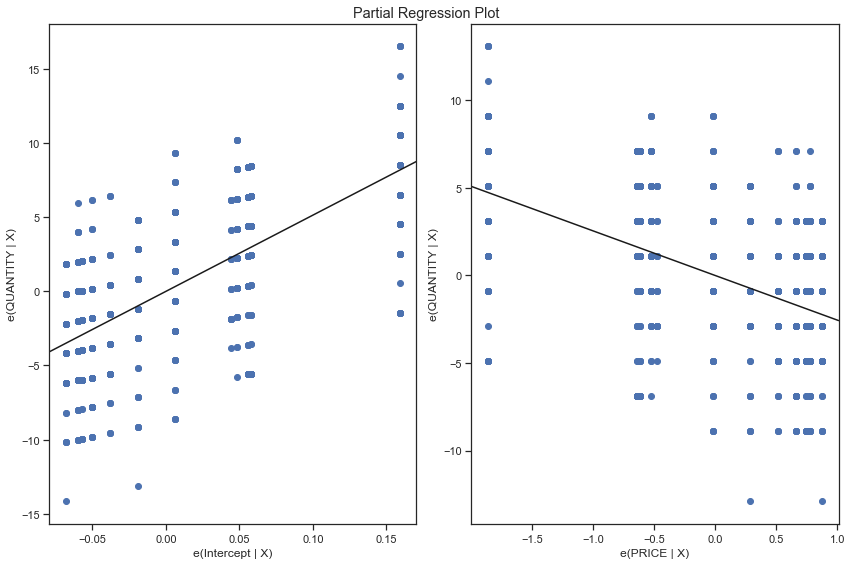

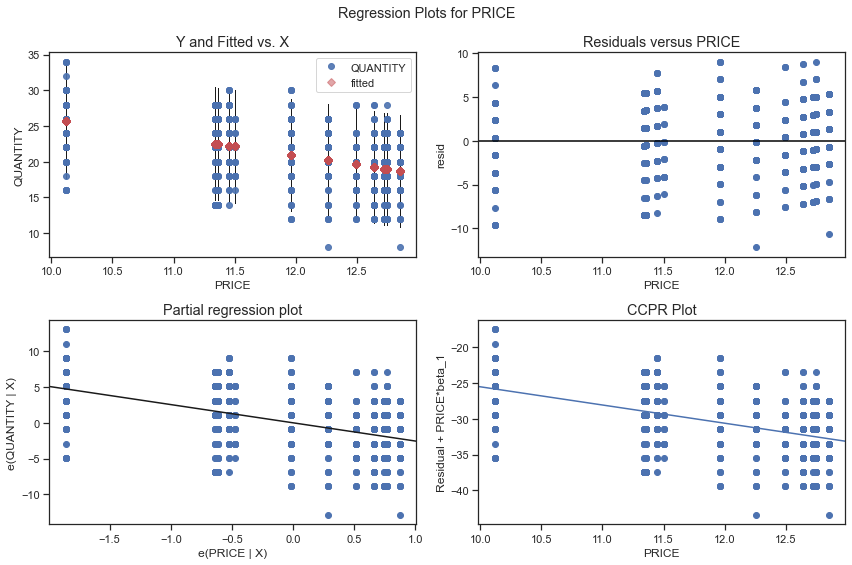

In [100]:
model = ols("QUANTITY ~ PRICE", data=df).fit()
print(model.summary())
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'PRICE', fig=fig)

In [101]:
elasticities = {}
def create_model_and_find_elasticity(data):
    model = ols("QUANTITY ~ PRICE", data).fit()
    price_elasticity = model.params[1]
    print("Price elasticity of the product: " + str(price_elasticity))
    print(model.summary())
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    return price_elasticity, model

Price elasticity of the product: -8.658581488470578
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     1804.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):          5.51e-153
Time:                        15:41:53   Log-Likelihood:                -1038.8
No. Observations:                 416   AIC:                             2082.
Df Residuals:                     414   BIC:                             2090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


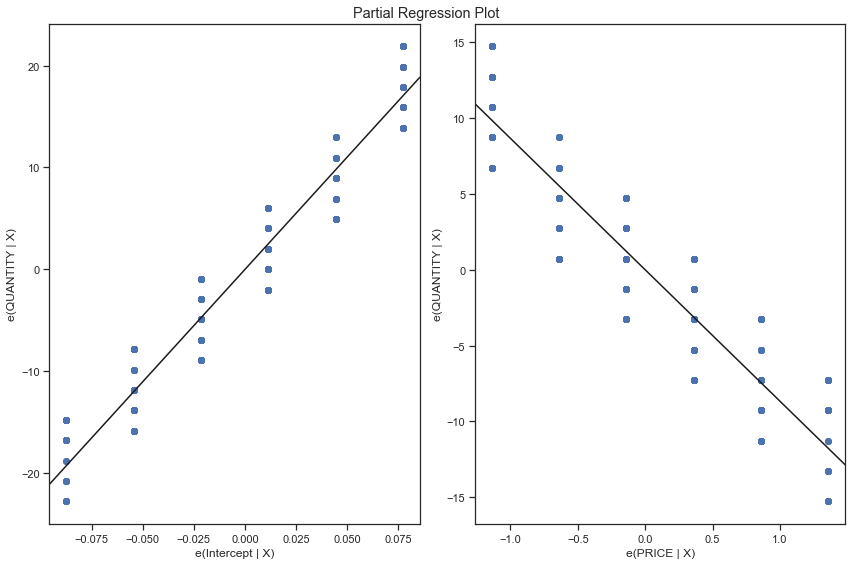

In [102]:
price_elasticity, model_burger_1070 = create_model_and_find_elasticity(burger_1070)
elasticities['burger_1070'] = price_elasticity

Price elasticity of the product: -3.618990615456308
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     363.3
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.34e-58
Time:                        15:42:02   Log-Likelihood:                -1021.5
No. Observations:                 416   AIC:                             2047.
Df Residuals:                     414   BIC:                             2055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


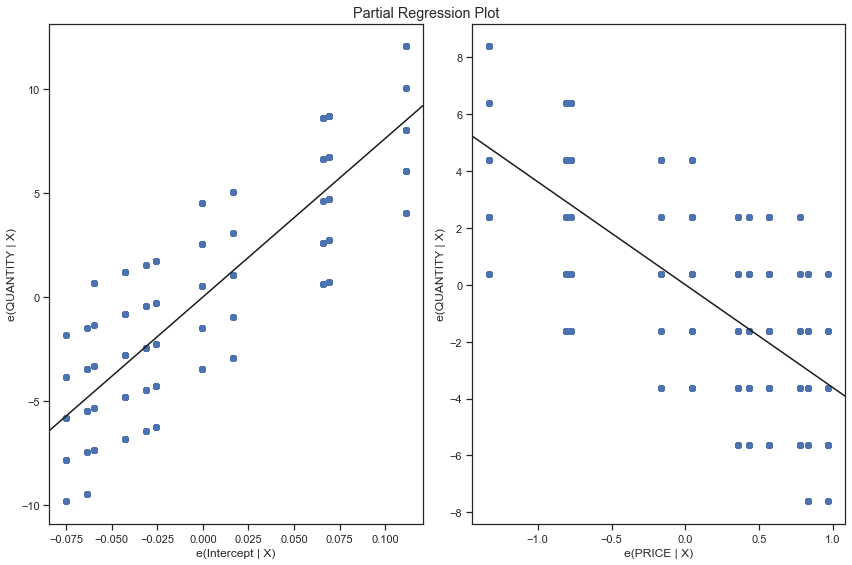

In [103]:
burger2051_data = bau2_data[(bau2_data['ITEM_NAME'] == "BURGER") & (bau2_data['SELL_ID'] == 2051)]
elasticities['burger_2051'], model_burger_2051 = create_model_and_find_elasticity(burger2051_data)

Price elasticity of the product: -2.8567029845599614
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     316.5
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           5.32e-53
Time:                        15:42:07   Log-Likelihood:                -1014.7
No. Observations:                 416   AIC:                             2033.
Df Residuals:                     414   BIC:                             2041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

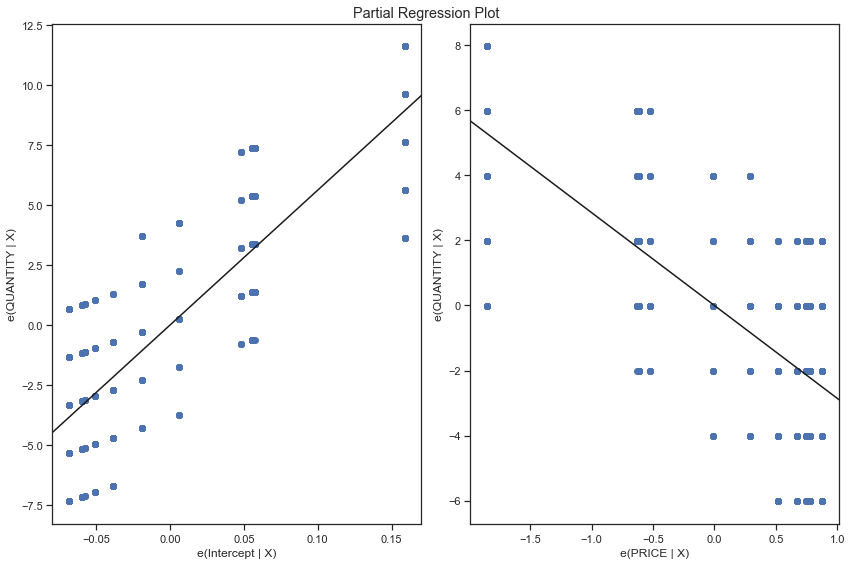

In [104]:
burger2052_data = bau2_data[(bau2_data['ITEM_NAME'] == "BURGER") & (bau2_data['SELL_ID'] == 2052)]
elasticities['burger_2052'], model_burger_2052 = create_model_and_find_elasticity(burger2052_data)

Price elasticity of the product: -6.1641566662301495
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):          3.72e-152
Time:                        15:42:10   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

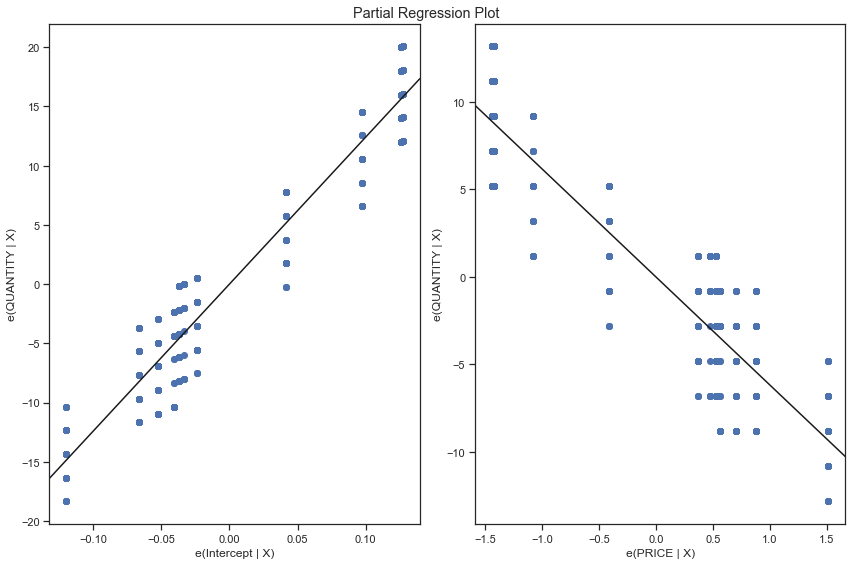

In [105]:
burger2053_data = bau2_data[(bau2_data['ITEM_NAME'] == "BURGER") & (bau2_data['SELL_ID'] == 2053)]
elasticities['burger_2053'], model_burger_2053 = create_model_and_find_elasticity(burger2053_data)

Price elasticity of the product: -7.460103485084974
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     466.3
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           2.00e-82
Time:                        15:42:12   Log-Likelihood:                -2994.5
No. Observations:                 832   AIC:                             5993.
Df Residuals:                     830   BIC:                             6002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


(-7.460103485084974,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x213dd664eb0>)

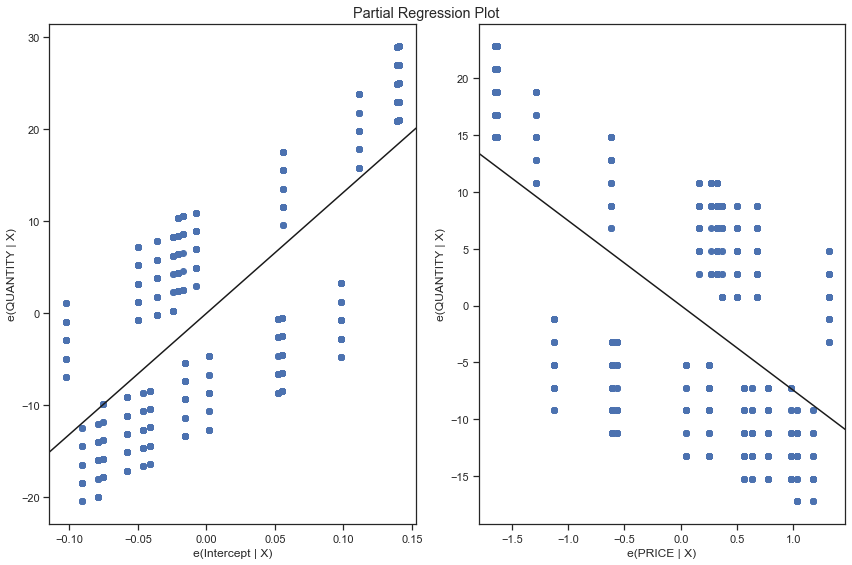

In [106]:
coke_data = bau2_data[bau2_data['ITEM_NAME'] == "COKE"]
create_model_and_find_elasticity(coke_data)

2 coke are available in combo, while 1 is available as single.. So it is likely that the bottom distribution belongs to single purchases of coke. Let's verfy this

In [108]:
coke_data = bau2_data[(bau2_data['ITEM_NAME'] == "COKE") & (bau2_data['SELL_ID'] == 3067)]
elasticities['coke_3067'], model_coke_3067 = create_model_and_find_elasticity(coke_data)

ValueError: zero-size array to reduction operation maximum which has no identity

In [109]:
coke_data

Empty DataFrame
Columns: [SELL_ID, SELL_CATEGORY, ITEM_NAME, CALENDAR_DATE, PRICE, QUANTITY, YEAR, HOLIDAY, IS_WEEKEND, IS_SCHOOLBREAK, AVERAGE_TEMPERATURE, IS_OUTDOOR]
Index: []

Price elasticity of the product: -6.1641566662301495
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):          3.72e-152
Time:                        15:44:42   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

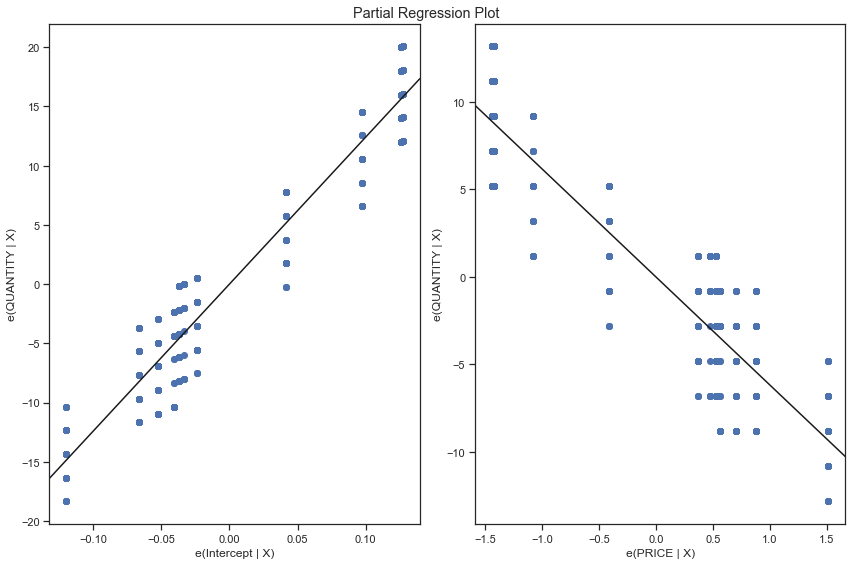

In [110]:
coke_data_2053 = bau2_data[(bau2_data['ITEM_NAME'] == "COKE") & (bau2_data['SELL_ID'] == 2053)]
elasticities['coke_2053'], model_coke_2053 = create_model_and_find_elasticity(coke_data_2053)

Price elasticity of the product: -3.618990615456308
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     363.3
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           1.34e-58
Time:                        15:44:49   Log-Likelihood:                -1021.5
No. Observations:                 416   AIC:                             2047.
Df Residuals:                     414   BIC:                             2055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


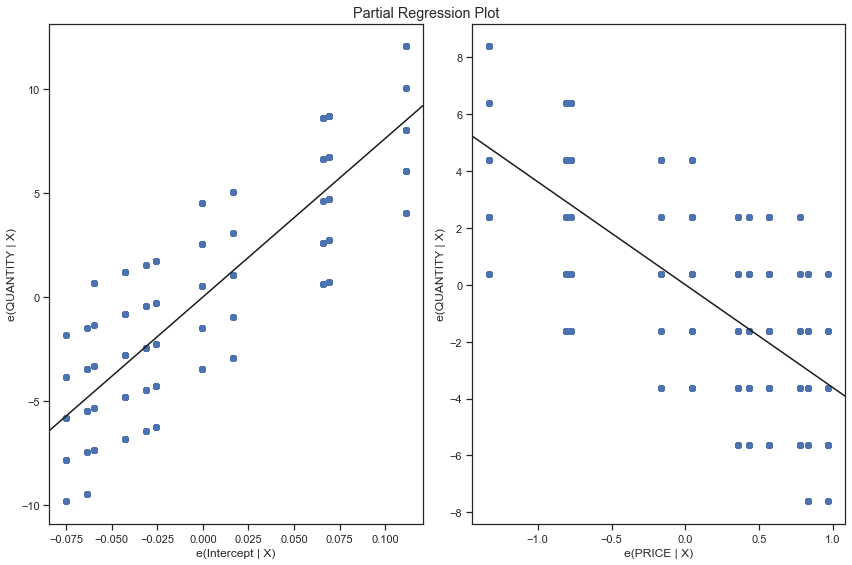

In [111]:
coke_data_2051 = bau2_data[(bau2_data['ITEM_NAME'] == "COKE") & (bau2_data['SELL_ID'] == 2051)]
elasticities['coke_2051'], model_coke_2051 = create_model_and_find_elasticity(coke_data_2051)


Price elasticity of the product: -2.8567029845599614
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     316.5
Date:                Mon, 26 Jul 2021   Prob (F-statistic):           5.32e-53
Time:                        15:44:53   Log-Likelihood:                -1014.7
No. Observations:                 416   AIC:                             2033.
Df Residuals:                     414   BIC:                             2041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

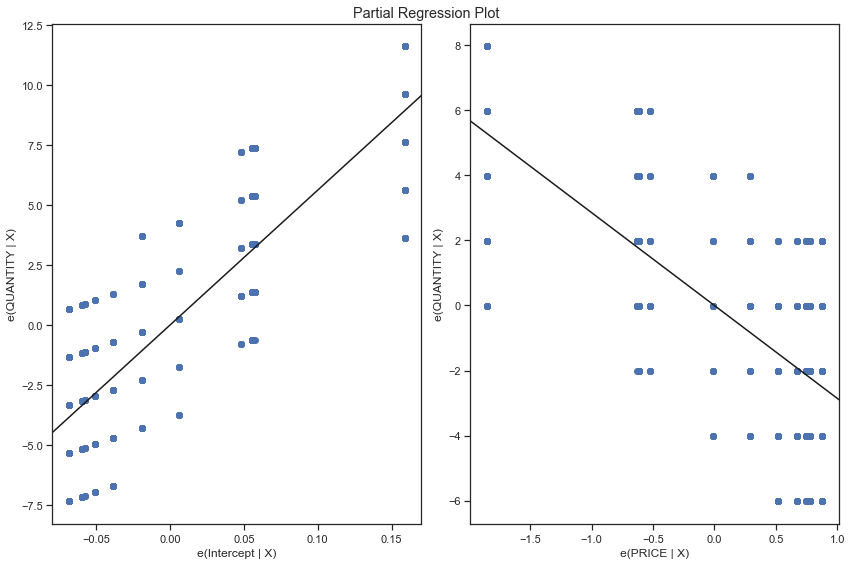

In [112]:
lemonade_data_2052 = bau2_data[(bau2_data['ITEM_NAME'] == "LEMONADE") & (bau2_data['SELL_ID'] == 2052)]
elasticities['lemonade_2052'], model_lemonade_2052 = create_model_and_find_elasticity(lemonade_data_2052)

In [113]:
lemonade_data_3028 = bau2_data[(bau2_data['ITEM_NAME'] == "LEMONADE") & (bau2_data['SELL_ID'] == 3028)]
elasticities['lemonade_3028'], model_lemonade_3028 = create_model_and_find_elasticity(lemonade_data_3028)

ValueError: zero-size array to reduction operation maximum which has no identity

Price elasticity of the product: -6.1641566662301495
                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     1784.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):          3.72e-152
Time:                        15:45:03   Log-Likelihood:                -1035.7
No. Observations:                 416   AIC:                             2075.
Df Residuals:                     414   BIC:                             2083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

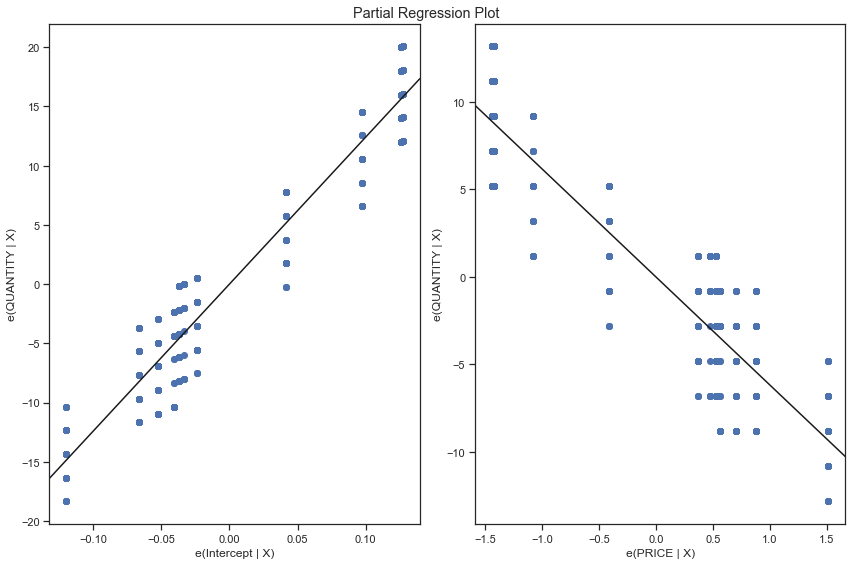

In [114]:
coffee_data_2053 = bau2_data[(bau2_data['ITEM_NAME'] == "COFFEE") & (bau2_data['SELL_ID'] == 2053)]
elasticities['coffee_2053'], model_coffee_2053 = create_model_and_find_elasticity(coffee_data_2053)

In [115]:
coffee_data_3055 = bau2_data[(bau2_data['ITEM_NAME'] == "COFFEE") & (bau2_data['SELL_ID'] == 3055)]
elasticities['coffee_3055'], model_coffee_3055 = create_model_and_find_elasticity(coffee_data_3055)

ValueError: zero-size array to reduction operation maximum which has no identity

## 5. List in a table the items and their price elasticities

In [116]:
elasticities

{'burger_1070': -8.658581488470578,
 'burger_2051': -3.618990615456308,
 'burger_2052': -2.8567029845599614,
 'burger_2053': -6.1641566662301495,
 'coke_2053': -6.1641566662301495,
 'coke_2051': -3.618990615456308,
 'lemonade_2052': -2.8567029845599614,
 'coffee_2053': -6.1641566662301495}

## 6. Find optimal price for maximum profit

Now, let's take coke (the sell_id was 2051 for the last coke data) and since we do not the buying price of coke, let''s assume it to be a little less than the minimum coke price in the dataset

In [117]:
coke_data = coke_data_2053

In [118]:
coke_data.PRICE.min()

10.45

In [119]:
coke_data.PRICE.max()

13.41

Let's take 9 as the buying price of coke. We now want to be able to set the price of coke to get the maximum profit. PRICE is the selling price

In [120]:
buying_price_coke = 9

$$coke data.PROFIT = (coke data.PRICE - buying price coke) * coke data.QUANTITY$$
Let's see the profit for various price points:

In [121]:
start_price = 9.5
end_price = 20

In [122]:
test = pd.DataFrame(columns = ["PRICE", "QUANTITY"])

In [123]:
test['PRICE'] = np.arange(start_price, end_price,0.01)

In [124]:
test['QUANTITY'] = model_coke_2051.predict(test['PRICE'])

In [125]:
test

PRICE   QUANTITY
0      9.50  41.759021
1      9.51  41.722831
2      9.52  41.686641
3      9.53  41.650451
4      9.54  41.614261
5      9.55  41.578071
6      9.56  41.541881
7      9.57  41.505691
8      9.58  41.469501
9      9.59  41.433312
10     9.60  41.397122
11     9.61  41.360932
12     9.62  41.324742
13     9.63  41.288552
14     9.64  41.252362
15     9.65  41.216172
16     9.66  41.179982
17     9.67  41.143792
18     9.68  41.107602
19     9.69  41.071412
20     9.70  41.035223
21     9.71  40.999033
22     9.72  40.962843
23     9.73  40.926653
24     9.74  40.890463
25     9.75  40.854273
26     9.76  40.818083
27     9.77  40.781893
28     9.78  40.745703
29     9.79  40.709513
30     9.80  40.673324
31     9.81  40.637134
32     9.82  40.600944
33     9.83  40.564754
34     9.84  40.528564
35     9.85  40.492374
36     9.86  40.456184
37     9.87  40.419994
38     9.88  40.383804
39     9.89  40.347614
40     9.90  40.311424
41     9.91  40.275235
42     9.92  40.239045
43     9.93  40.202855
44     9.94  40.166665
45     9.95  40.130475
46     9.96  40.094285
47     9.97  40.058095
48     9.98  40.021905
49     9.99  39.985715
50    10.00  39.949525
51    10.01  39.913335
52    10.02  39.877146
53    10.03  39.840956
54    10.04  39.804766
55    10.05  39.768576
56    10.06  39.732386
57    10.07  39.696196
58    10.08  39.660006
59    10.09  39.623816
60    10.10  39.587626
61    10.11  39.551436
62    10.12  39.515247
63    10.13  39.479057
64    10.14  39.442867
65    10.15  39.406677
66    10.16  39.370487
67    10.17  39.334297
68    10.18  39.298107
69    10.19  39.261917
70    10.20  39.225727
71    10.21  39.189537
72    10.22  39.153347
73    10.23  39.117158
74    10.24  39.080968
75    10.25  39.044778
76    10.26  39.008588
77    10.27  38.972398
78    10.28  38.936208
79    10.29  38.900018
80    10.30  38.863828
81    10.31  38.827638
82    10.32  38.791448
83    10.33  38.755258
84    10.34  38.719069
85    10.35  38.682879
86    10.36  38.646689
87    10.37  38.610499
88    10.38  38.574309
89    10.39  38.538119
90    10.40  38.501929
91    10.41  38.465739
92    10.42  38.429549
93    10.43  38.393359
94    10.44  38.357170
95    10.45  38.320980
96    10.46  38.284790
97    10.47  38.248600
98    10.48  38.212410
99    10.49  38.176220
100   10.50  38.140030
101   10.51  38.103840
102   10.52  38.067650
103   10.53  38.031460
104   10.54  37.995270
105   10.55  37.959081
106   10.56  37.922891
107   10.57  37.886701
108   10.58  37.850511
109   10.59  37.814321
110   10.60  37.778131
111   10.61  37.741941
112   10.62  37.705751
113   10.63  37.669561
114   10.64  37.633371
115   10.65  37.597181
116   10.66  37.560992
117   10.67  37.524802
118   10.68  37.488612
119   10.69  37.452422
120   10.70  37.416232
121   10.71  37.380042
122   10.72  37.343852
123   10.73  37.307662
124   10.74  37.271472
125   10.75  37.235282
126   10.76  37.199093
127   10.77  37.162903
128   10.78  37.126713
129   10.79  37.090523
130   10.80  37.054333
131   10.81  37.018143
132   10.82  36.981953
133   10.83  36.945763
134   10.84  36.909573
135   10.85  36.873383
136   10.86  36.837193
137   10.87  36.801004
138   10.88  36.764814
139   10.89  36.728624
140   10.90  36.692434
141   10.91  36.656244
142   10.92  36.620054
143   10.93  36.583864
144   10.94  36.547674
145   10.95  36.511484
146   10.96  36.475294
147   10.97  36.439104
148   10.98  36.402915
149   10.99  36.366725
150   11.00  36.330535
151   11.01  36.294345
152   11.02  36.258155
153   11.03  36.221965
154   11.04  36.185775
155   11.05  36.149585
156   11.06  36.113395
157   11.07  36.077205
158   11.08  36.041016
159   11.09  36.004826
160   11.10  35.968636
161   11.11  35.932446
162   11.12  35.896256
163   11.13  35.860066
164   11.14  35.823876
165   11.15  35.787686
166   11.16  35.751496
167   11.17  35.715306
168   11.18  35.679116
169   11.19  35.642927
170   11.20  35.606737
171   11.21  35.570547
172   11.22  35.534357
173 

In [126]:
test['PROFIT'] = (test["PRICE"] - buying_price_coke) * test["QUANTITY"]

In [127]:
test

PRICE   QUANTITY      PROFIT
0      9.50  41.759021   20.879510
1      9.51  41.722831   21.278644
2      9.52  41.686641   21.677053
3      9.53  41.650451   22.074739
4      9.54  41.614261   22.471701
5      9.55  41.578071   22.867939
6      9.56  41.541881   23.263454
7      9.57  41.505691   23.658244
8      9.58  41.469501   24.052311
9      9.59  41.433312   24.445654
10     9.60  41.397122   24.838273
11     9.61  41.360932   25.230168
12     9.62  41.324742   25.621340
13     9.63  41.288552   26.011788
14     9.64  41.252362   26.401512
15     9.65  41.216172   26.790512
16     9.66  41.179982   27.178788
17     9.67  41.143792   27.566341
18     9.68  41.107602   27.953170
19     9.69  41.071412   28.339275
20     9.70  41.035223   28.724656
21     9.71  40.999033   29.109313
22     9.72  40.962843   29.493247
23     9.73  40.926653   29.876457
24     9.74  40.890463   30.258943
25     9.75  40.854273   30.640705
26     9.76  40.818083   31.021743
27     9.77  40.781893   31.402058
28     9.78  40.745703   31.781649
29     9.79  40.709513   32.160516
30     9.80  40.673324   32.538659
31     9.81  40.637134   32.916078
32     9.82  40.600944   33.292774
33     9.83  40.564754   33.668746
34     9.84  40.528564   34.043994
35     9.85  40.492374   34.418518
36     9.86  40.456184   34.792318
37     9.87  40.419994   35.165395
38     9.88  40.383804   35.537748
39     9.89  40.347614   35.909377
40     9.90  40.311424   36.280282
41     9.91  40.275235   36.650463
42     9.92  40.239045   37.019921
43     9.93  40.202855   37.388655
44     9.94  40.166665   37.756665
45     9.95  40.130475   38.123951
46     9.96  40.094285   38.490514
47     9.97  40.058095   38.856352
48     9.98  40.021905   39.221467
49     9.99  39.985715   39.585858
50    10.00  39.949525   39.949525
51    10.01  39.913335   40.312469
52    10.02  39.877146   40.674688
53    10.03  39.840956   41.036184
54    10.04  39.804766   41.396956
55    10.05  39.768576   41.757005
56    10.06  39.732386   42.116329
57    10.07  39.696196   42.474930
58    10.08  39.660006   42.832807
59    10.09  39.623816   43.189960
60    10.10  39.587626   43.546389
61    10.11  39.551436   43.902094
62    10.12  39.515247   44.257076
63    10.13  39.479057   44.611334
64    10.14  39.442867   44.964868
65    10.15  39.406677   45.317678
66    10.16  39.370487   45.669765
67    10.17  39.334297   46.021127
68    10.18  39.298107   46.371766
69    10.19  39.261917   46.721681
70    10.20  39.225727   47.070873
71    10.21  39.189537   47.419340
72    10.22  39.153347   47.767084
73    10.23  39.117158   48.114104
74    10.24  39.080968   48.460400
75    10.25  39.044778   48.805972
76    10.26  39.008588   49.150821
77    10.27  38.972398   49.494945
78    10.28  38.936208   49.838346
79    10.29  38.900018   50.181023
80    10.30  38.863828   50.522977
81    10.31  38.827638   50.864206
82    10.32  38.791448   51.204712
83    10.33  38.755258   51.544494
84    10.34  38.719069   51.883552
85    10.35  38.682879   52.221886
86    10.36  38.646689   52.559497
87    10.37  38.610499   52.896383
88    10.38  38.574309   53.232546
89    10.39  38.538119   53.567985
90    10.40  38.501929   53.902701
91    10.41  38.465739   54.236692
92    10.42  38.429549   54.569960
93    10.43  38.393359   54.902504
94    10.44  38.357170   55.234324
95    10.45  38.320980   55.565420
96    10.46  38.284790   55.895793
97    10.47  38.248600   56.225442
98    10.48  38.212410   56.554367
99    10.49  38.176220   56.882568
100   10.50  38.140030   57.210045
101   10.51  38.103840   57.536799
102   10.52  38.067650   57.862828
103   10.53  38.031460   58.188134
104   10.54  37.995270   58.512717
105   10.55  37.959081   58.836575
106   10.56  37.922891   59.159709
107   10.57  37.886701   59.482120
108   10.58  37.850511   59.803807
109   10.59  37.814321   60.124770
110   10.60  37.778131   60.445010
111   10.61  37.741941   60.764525
112   10.62  37.705751   61.083317
113   10.63  37.

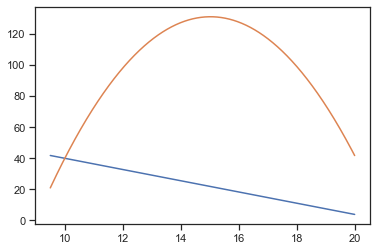

In [128]:
plt.plot(test['PRICE'],test['QUANTITY'])
plt.plot(test['PRICE'],test['PROFIT'])
plt.show()

Let's find the exact price at which maximum profit is gained:

In [129]:
ind = np.where(test['PROFIT'] == test['PROFIT'].max())[0][0]

In [130]:
test.loc[[ind]]

PRICE   QUANTITY      PROFIT
552  15.02  21.782193  131.128799

In [131]:
def find_optimal_price(data, model, buying_price):
    start_price = data.PRICE.min() - 1
    end_price = data.PRICE.min() + 10
    test = pd.DataFrame(columns = ["PRICE", "QUANTITY"])
    test['PRICE'] = np.arange(start_price, end_price,0.01)
    test['QUANTITY'] = model.predict(test['PRICE'])
    test['PROFIT'] = (test["PRICE"] - buying_price) * test["QUANTITY"]
    plt.plot(test['PRICE'],test['QUANTITY'])
    plt.plot(test['PRICE'],test['PROFIT'])
    plt.show()
    ind = np.where(test['PROFIT'] == test['PROFIT'].max())[0][0]
    values_at_max_profit = test.iloc[[ind]]
    return values_at_max_profit
    

## 7. Calculate the optimal price for all and list in table

In [132]:
optimal_price = {}
buying_price = 9

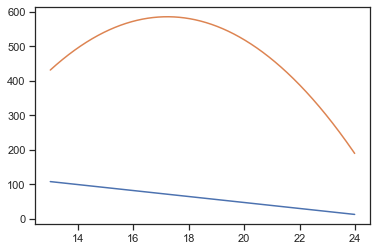

In [133]:
optimal_price['burger_1070'] = find_optimal_price(burger_1070, model_burger_1070, buying_price)

In [134]:
optimal_price

{'burger_1070':      PRICE   QUANTITY      PROFIT
 422  17.22  71.259194  585.750572}

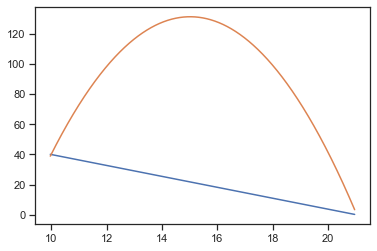

In [135]:
optimal_price['burger_2051'] = find_optimal_price(burger2051_data, model_burger_2051, buying_price)

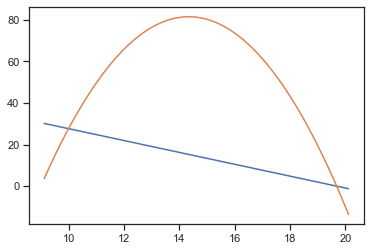

In [136]:
optimal_price['burger_2052'] = find_optimal_price(burger2052_data, model_burger_2052, buying_price)

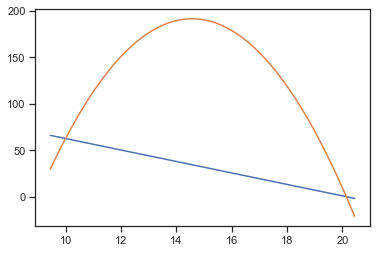

In [137]:
optimal_price['burger_2053'] = find_optimal_price(burger2053_data, model_burger_2053, buying_price)

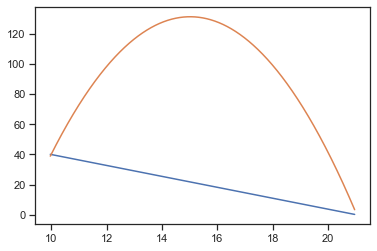

In [138]:
optimal_price['coke_2051'] = find_optimal_price(coke_data_2051, model_coke_2051, buying_price)

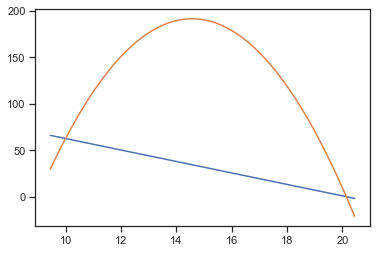

In [139]:
optimal_price['coke_2053'] = find_optimal_price(coke_data_2053, model_coke_2053, buying_price)

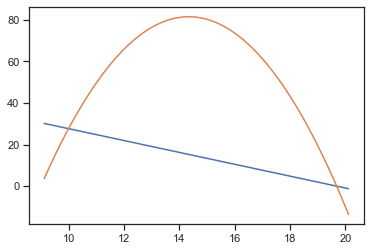

In [140]:
optimal_price['lemonade_2052'] = find_optimal_price(lemonade_data_2052, model_lemonade_2052, buying_price)

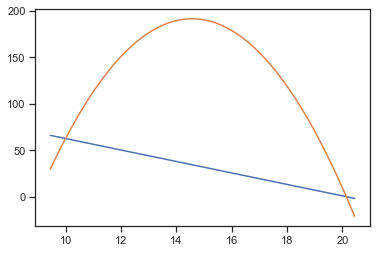

In [141]:
optimal_price['coffee_2053'] = find_optimal_price(coffee_data_2053, model_coffee_2053, buying_price)

In [142]:
optimal_price

{'burger_1070':      PRICE   QUANTITY      PROFIT
 422  17.22  71.259194  585.750572,
 'burger_2051':      PRICE   QUANTITY      PROFIT
 505  15.02  21.782193  131.128799,
 'burger_2052':      PRICE   QUANTITY     PROFIT
 522  14.34  15.259215  81.484211,
 'burger_2053':      PRICE   QUANTITY      PROFIT
 512  14.57  34.329951  191.217825,
 'coke_2051':      PRICE   QUANTITY      PROFIT
 505  15.02  21.782193  131.128799,
 'coke_2053':      PRICE   QUANTITY      PROFIT
 512  14.57  34.329951  191.217825,
 'lemonade_2052':      PRICE   QUANTITY     PROFIT
 522  14.34  15.259215  81.484211,
 'coffee_2053':      PRICE   QUANTITY      PROFIT
 512  14.57  34.329951  191.217825}

In [143]:
coke_data_2051.PRICE.describe()

count    416.000000
mean      12.301562
std        0.730620
min       10.970000
25%       11.530000
50%       12.350000
75%       12.870000
max       13.270000
Name: PRICE, dtype: float64

## 8. Conclusion

This is the price the cafe should set on it's item to earn maximum profit based on it's previous sales data. It is important to note that this is on a normal day. On 'other' days such as a holiday, or an event taking place have a different impact on customer buying behaviours and pattern. Usually an increase in consumption is seen on such days. These must be treated separately. Similarly, it is important to remove any external effects other than price that will affect the purchase behaviours of customers including the datapoints when the item was on discount.

Once, the new prices are put up, it is important to continuously monitor the sales and profit. If this method of pricing is a part of a rpoduct, a dashboard can be created for the purpose of monitoring these items and calculating the lift in the profit.